In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression 
from sklearn.preprocessing import StandardScaler
# from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
import statsmodels.stats.diagnostic as stm
import statsmodels.api as sm
from math import sqrt
from scipy.stats import ttest_ind
import pickle
import joblib
from math import log10
from listIO import list_reader,list_writer

%matplotlib inline

ModuleNotFoundError: No module named 'listIO'

In [ ]:
def get_stats(dataset, meta):

    rs = []
    stderrs = []

    for column in dataset:
    
        # get the individual CpG age-correlations and the standard errors
        regression = stats.linregress(meta.age.astype(float), dataset[column].astype(float))
        slope, intercept, rvalue, pvalue, stderr = regression
        rs+=[rvalue]
        stderrs+= [stderr]  
        
    return rs, stderrs

In [ ]:
# this function prepares a model dataset for getting the age-correlations;
# the dataset should be a dataframe with the first column containing the model 
# the second should contain the model weights or importance scores
def prep_dataset(data):
    # ensure the data has the correct column names
    data.columns = ['CpG', 'Weight']
    
    data = data.sort_values('CpG')
    
    return data

In [ ]:
#This function calculates the feature importances by t-values where t = weight/stderr for a feature
def get_tvals(weights,stderrs):
    
    tvals = []
    for i in range(len(weights)):
        tvals+=[weights[i]/stderrs[i]]
        
    return tvals     

In [ ]:
def cohens_d(s1, s2):
    
    import statistics
    

    diff = s2.mean()-s1.mean()
    
    n1 = len(s1)
    n2 = len(s2)
    sd1 = statistics.stdev(s1)
    sd2 = statistics.stdev(s2)
    
    pooled_sd = np.sqrt(((n1-1)*sd1**2+(n2-1)*sd2**2)/(n1+n2-2))
    
    return diff/pooled_sd

In [ ]:
# inputs: a reference dataset used to get the age-correlations for the CpGs, 
# and a dataframe of the CpGs and weights for a given model
# data in the model dataframe need to be sorted (A-Z) by CpG

def model_corrs(model, ref_data, meta):
        
    #Get the intersection of the CpGs between the model and the ref data; 
    intersect=list(set(ref_data.columns) & set(model.CpG))
    
    missing = list(set(model.CpG)-set(intersect)).sort()
    
    #need to sort the intersection to keep the lists synced
    intersect.sort()
    
    model = model.loc[model.CpG.isin(intersect)]
    
    #get the CpG values in the reference data for the intersection
    combined = ref_data[intersect]
    
    model_rs, stderrs = get_stats(combined,meta)
    
    #the model importances are given by their t-statistics
    importances = get_tvals(model.Weight.tolist(),stderrs)
    
    cg_corrs=pd.DataFrame({'CpG':combined.columns.tolist(), 'Weight': model.Weight.tolist(), 'r': model_rs, 't': importances})
    cg_corrs['R2'] = cg_corrs.r**2 
    
    return cg_corrs, missing  

In [ ]:
def normalized_importance(data):
    
    importances = abs(data.t)/abs(data.t).max()
    
    return importances

In [ ]:
#This function provides a measure of the noise with age by calculating the residuals for the age-correlation for a predictor, 
#then regresses those residuals on age and calulates and returns the R^2
def het_r(data, model, ages):
    
    #Get the intersection of the CpGs between the model and the ref data; 
    intersect=list(set(data.columns) & set(model.CpG))
        
    #need to sort the intersection to keep the lists synced
    intersect.sort()
    
    temp_data = data[intersect]
    
    het_rs=[]
    
    for cg in temp_data.columns:
        
        #regress a given predictor on age
        regression = stats.linregress(ages.astype(float), temp_data[cg].tolist())
        slope, intercept, rvalue, pvalue, stderr = regression
        
        preds=ages*slope+intercept
        actuals = temp_data[cg].tolist()
        
        #calculate the act
        abs_resids=abs(preds-actuals)
        
        #regress the residuals for the predictor on age
        regression = stats.linregress(ages.astype(float), abs_resids)
        slope, intercept, rvalue, pvalue, stderr = regression
        
        het_rs+=[rvalue*rvalue]
        
    
    return het_rs

In [3]:
def u_test(model, data1, data2):
    
    """
    Perform the Mann-Whitney U test on the beta values of two different sample groups 
    for a model's selected CpGs.

    This function computes the U statistic, p-value, and the negative logarithm (base 10) 
    of the p-value for each CpG site listed in the model, excluding the intercept. 
    It uses the Mann-Whitney U test, a nonparametric test for assessing whether two 
    independent samples come from the same distribution.

    Parameters:
    -----------
    model : object
        A model object that contains the following attribute:
        - `CpG`: a list of CpG site names, where the first element is typically 'Intercept' 
          and the rest are CpG site identifiers.
          
    data1 : pandas.DataFrame
        A DataFrame containing the beta values for the first group of samples. Each row 
        represents a sample, and each column represents a CpG site.
        
    data2 : pandas.DataFrame
        A DataFrame containing the beta values for the second group of samples. Each row 
        represents a sample, and each column represents a CpG site.

    Returns:
    --------
    stats : list
        A list of U statistics, one for each CpG site in the model (excluding the intercept).
    
    p_vals : list
        A list of p-values corresponding to each U statistic.
    
    log_p : list
        A list of the negative logarithm (base 10) of each p-value.

    Notes:
    ------
    - The intercept (first CpG in the model) is excluded from the analysis.
    - The Mann-Whitney U test is a nonparametric test, making it suitable for comparing 
      distributions without assuming normality.

    """
        
    from scipy.stats import mannwhitneyu
    # Perform the Mann-Whitney U test
    p_vals=[]
    stats =[]
    log_p=[]
    
    for cg in model.CpG[1:]:

        
        stat, p = mannwhitneyu(data1[cg].astype(float), data2[cg].astype(float))
        
        log_p += [-log10(p)]
        stats+=[stat]
        p_vals +=[p]
        
    return stats, p_vals, log_p

In [4]:
def get_preds(inputs, model):
    
    """
    Generate predictions for a given model using the provided input data.

    This function checks if the input data contains an intercept column; if not, 
    it adds one. It then verifies that the features in the input data match the 
    features expected by the model. If they do, it computes predictions by taking 
    the dot product of the model weights and the input features for each row of data.

    Parameters:
    -----------
    inputs : pandas.DataFrame
        A DataFrame containing the input data. Each row represents a sample, and 
        each column represents a feature. If the first column is not named 'Intercept', 
        the function will add a column of ones as the intercept.
        
    model : object
        A model object that has the following attributes:
        - `CpG`: a list of feature names that the model expects (including 'Intercept').
        - `Weight`: a numpy array or pandas Series containing the model weights, 
          where the order corresponds to the features listed in `CpG`.

    Returns:
    --------
    list
        A list of predictions, one for each row in the input data.

    Raises:
    -------
    ValueError
        If the features in the input data do not match the features expected by the model.
    """
    
    if inputs.columns[0]!='Intercept':
        # Insert a column of ones at the front
        inputs.insert(0, 'Intercept', 1)
    
    if inputs.columns.tolist()[1:]==model.CpG.tolist()[1:]:
        
        preds = []

        for row in inputs.index.tolist():
            # Calculate the dot product
            preds+= [model.Weight.dot(inputs.loc[row].values)]
        return preds
        
    else:
        return print('error: feature mismatch')

In [5]:
def get_horvath(inputs, model):
    
    if inputs.columns[0]!='Intercept':
        # Insert a column of ones at the front
        inputs.insert(0, 'Intercept', 1)
    
    if inputs.columns.tolist()[1:]==model.CpG.tolist()[1:]:
        
        preds = []

        for row in inputs.index.tolist():
            # Calculate the dot product
            out = model.Weight.dot(inputs.loc[row].values)
            
            if out <= 0:
                
                preds+=[21*10**out -1]
                
            else:
                
                preds+=[21*out+20]
                
        return preds
        
    else:
        return print('error: feature mismatch')

In [6]:
# def get_hets(df, ages):
    
    
#     hets =[]
    
#     for cg in df.columns:
    
#         x = df[cg].tolist()

#         #add constant to predictor variables
#         x = sm.add_constant(x)

#         #fit regression model
#         model = sm.OLS(ages, x).fit()

#         #perform White's test
#         white_test = stm.het_white(model.resid,  model.model.exog)
#         RSS = sum(model.resid**2)

#         hets +=[white_test[0]/sqrt(RSS)]
#     return hets

In [14]:
# def diffs_v_importance(data, corrs, ages, name):
    
#     diffs=resid_diffs(data,ages)
    
#     plt.figure(figsize=(9, 6))
#     xlim=[0,1]
#     ylim=[0,1]
    
#     #plt.plot(abs(data.r).mean()*np.ones(100), np.linspace(0,1,100), linestyle='--', color='r', linewidth=3.5)
#     plt.scatter(abs(corrs.t)/abs(corrs.t).max(),diffs, s=150, edgecolor='k')
# #     plt.xlim(xlim)
#     # plt.ylim(ylim)

#     plt.xlabel('Normalized importance' ,fontsize=15)
#     plt.ylabel('O-Y noise' ,fontsize=15)

#     plt.title('{} (p={})'.format(name, len(data.columns)), fontsize=15)
#     plt.xticks(fontsize=15)
#     plt.yticks(fontsize=15)

#     plt.savefig('Datasets/Clock cpgs/{}_noise_v_weight'.format(name), dpi=300)  

In [15]:
# def resid_diffs(data, ages):
    
#     diffs=[]
    
#     for cg in data.columns:
#         regression = stats.linregress(ages.astype(float), data[cg].tolist())
#         slope, intercept, rvalue, pvalue, stderr = regression
        
#         preds=ages*slope+intercept
#         actuals = data[cg].tolist()
        
#         abs_resids=abs(preds-actuals)
        
#         diffs+=[abs_resids[ages>75].mean()-abs_resids[ages<35][ages>26].mean()]
    
#     return diffs

In [16]:
# def importance_v_het(data, corrs, ages, name):
    
#     hets = het_r(data,ages)
    
#     plt.figure(figsize=(7.75, 6))
#     xlim=[0,1]
#     ylim=[-1e-5,5e-4]
    
#     plt.plot(np.linspace(0,1,100),sum(hets)/len(hets)*np.ones(100), linestyle='--', color='r', linewidth=3.5)
#     plt.scatter(abs(corrs.t)/abs(corrs.t).max(),hets, s=150, edgecolor='k')
# #     plt.xlim(xlim)
#     plt.ylim(ylim)

#     plt.xlabel('Normalized importance' ,fontsize=15)
#     plt.ylabel('Noise score' ,fontsize=15)

#     plt.title('{} (p={})'.format(name, len(data.columns)), fontsize=15)
#     plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))


#     plt.xticks(fontsize=15)
#     plt.yticks(fontsize=15)

#     plt.savefig('Datasets/Clock cpgs/{}_het_v_weight'.format(name), dpi=300)  

Load in the reference data: in this case the arthritis and depression datasets since they have all CpGs

In [17]:
# h_comb = np.load('Datasets/Combined/V7_healthy.npy', allow_pickle=True)
# d_comb = np.load('Datasets/Combined/V7_disease.npy', allow_pickle=True)
# cgs=list_reader('Datasets/Combined/V7_cgs.txt')
# h_comb = pd.DataFrame(h_comb, columns=cgs)
# d_comb = pd.DataFrame(d_comb, columns=cgs)

In [8]:
v7_meta = pd.read_excel('Datasets/Combined/V7_pmeta.xlsx')
h_meta = v7_meta.copy()
d_meta = v7_meta.copy()
h_meta = h_meta[h_meta.healthy==0]
d_meta = d_meta[d_meta.healthy==1]
h_meta.reset_index(drop=True, inplace=True)
d_meta.reset_index(drop=True, inplace=True)

In [19]:
# art = np.load('Datasets/Arthritis/Arthritis_full.npy', allow_pickle=True)
# art_meta = pd.read_excel('Datasets/Arthritis/Arthritis_pmeta.xlsx')
# cgs=list_reader('Datasets/Arthritis/cgs_full.txt')
# art = pd.DataFrame(art, columns=cgs)

In [20]:
# dep = np.load('Datasets/Depression/Depression_full.npy', allow_pickle=True)
# dep_meta = pd.read_excel('Datasets/Depression/Depression_pmeta.xlsx')
# cg_list = list_reader('Datasets/Depression/cgs_full.txt')
# dep = pd.DataFrame(dep, columns=cg_list)

In [21]:
# park = pd.read_pickle('Datasets/Parkinsons Horvath/Parkinsons.pkl')
# park_meta = pd.read_excel('Datasets/Parkinsons Horvath/Parkinsons_pmeta.xlsx')
# park=park.reset_index(drop=True)
# from sklearn.impute import KNNImputer
# # Create an instance of KNNImputer
# imputer = KNNImputer(n_neighbors=2)
# # Fit and transform the DataFrame with the imputer
# imputed = imputer.fit_transform(park)
# park = pd.DataFrame(imputed, columns=park.columns)

In [22]:
# ms = pd.read_pickle('Datasets/MS/MS.pkl')
# ms_meta = pd.read_excel('Datasets/MS/MS_pmeta.xlsx')
# from sklearn.impute import KNNImputer
# # Create an instance of KNNImputer
# imputer = KNNImputer(n_neighbors=2)
# # Fit and transform the DataFrame with the imputer
# imputed = imputer.fit_transform(ms)
# ms = pd.DataFrame(imputed, columns=ms.columns)

In [23]:
# art_d = art[art_meta.healthy==1]
# dep_d = dep[dep_meta.healthy==1]
# park_d = park[park_meta.healthy==1]
# ms_d = ms[ms_meta.healthy==1]

In [9]:
comb = pd.concat([art_d, dep_d, park_d, ms_d], axis=0)
comb.reset_index(drop=True,inplace=True)
comb.shape[0]==sum(v7_meta.healthy==1)
arr=comb.values

In [10]:
# np.save('Datasets/Combined/V7_disease.npy', arr)

In [18]:
v7_h = np.load('Datasets/Combined/V7_healthy.npy', allow_pickle=True)
v7_meta = pd.read_excel('Datasets/Combined/V7_pmeta.xlsx')
v7_cgs = list_reader('Datasets/Combined/V7_cgs.txt')
v7_h = pd.DataFrame(v7_h, columns=v7_cgs)

In [16]:
v7_disease = v7_disease.astype(np.float32)

In [17]:
np.save('Datasets/Combined/V7_disease.npy', v7_disease)

An example CpG with high noise with age, and what we want to test for (old should have a higher mean absolute value of residuals than young)

In [40]:
regression = stats.linregress(ages.Age.astype(float), horvath_intersect[horvath_intersect.columns[67]].tolist())
slope, intercept, rvalue, pvalue, stderr = regression

In [47]:
horvath_intersect.columns[67]

'cg05250458'

Text(0.5, 1.0, 'cg05250458')

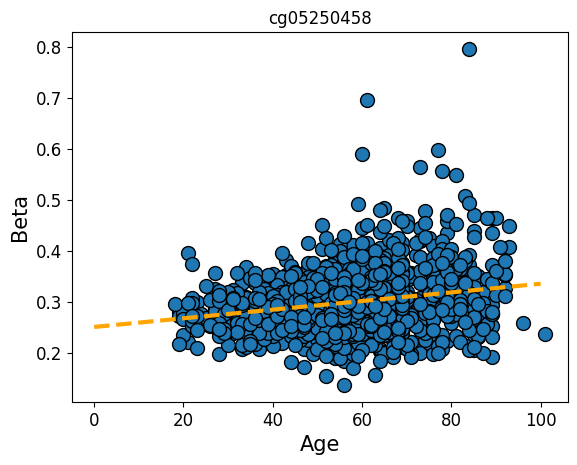

In [60]:
plt.scatter(ages.Age,horvath_intersect[horvath_intersect.columns[67]].tolist(), s=100, edgecolor='k')
plt.plot(np.linspace(0,100,101),np.linspace(0,100,101)*slope+intercept, color='orange', linestyle='--',linewidth=3)
plt.xlabel('Age', fontsize=15)
plt.ylabel('Beta', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('{}'.format(horvath_intersect.columns[67]))

In [176]:
actuals = horvath_intersect[horvath_intersect.columns[67]].tolist()

In [177]:
preds = ages.Age*slope + intercept

In [178]:
#calculate the act
abs_resids=abs(preds-actuals)
       
#regress the residuals for the predictor on age
regression2 = stats.linregress(ages.Age.astype(float), abs_resids)
slope2, intercept2, rvalue2, pvalue2, stderr2 = regression2

In [181]:
print('slope: ', slope2)
print('y-intercept: ', intercept2)

slope:  0.0006200231239045507
y-intercept:  0.005061462983348544


Text(0.5, 1.0, 'cg05250458')

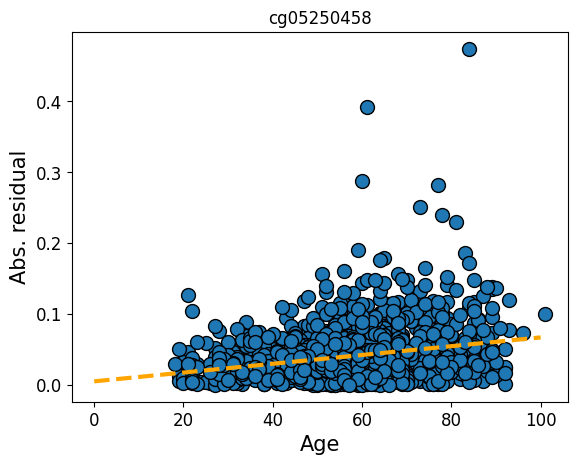

In [72]:
plt.scatter(ages.Age,abs_resids, s=100, edgecolor='k')
plt.plot(np.linspace(0,100,101),np.linspace(0,100,101)*slope2+intercept2, color='orange', linestyle='--',linewidth=3)
plt.xlabel('Age', fontsize=15)
plt.ylabel('Abs. residual', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('{}'.format(horvath_intersect.columns[67]))

In [251]:
model_stats=[]
d_model_stats=[]

# AdaptAge

In [252]:
adapt = pd.read_csv('Models/AdaptAge/AdaptAge.csv')
adapt=prep_dataset(adapt)
# adapt_corrs, missing = model_corrs(adapt, h_adapt, h_meta)
# adapt_corrs['importance'] = normalized_importance(adapt_corrs, 'AdaptAge')
# sns.scatterplot(data=adapt_corrs, x='importance', y='R2')
# adapt_corrs['het_rs'] = het_r(h_adapt, adapt, h_meta.age)
# intersect = list(set(h_adapt.columns)&set(adapt.CpG))
# intersect.sort()
# d_adapt = d_comb[intersect]
# h_adapt = h_comb[intersect]
h_adapt = pd.read_pickle('Models/AdaptAge/Healthy.pkl')
d_adapt = pd.read_pickle('Models/AdaptAge/Disease.pkl')

In [253]:
h_meta.loc[:, 'AdaptAge'] = get_preds(h_adapt, adapt)
d_meta.loc[:, 'AdaptAge'] = get_preds(d_adapt, adapt)

In [254]:
comb_meta = pd.concat([h_meta,d_meta], axis=0)

<AxesSubplot: xlabel='age', ylabel='AdaptAge'>

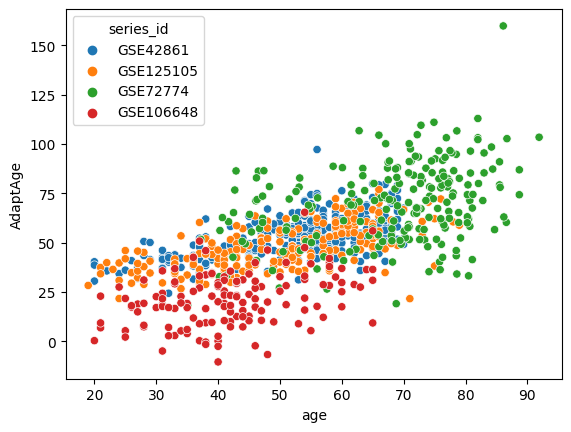

In [255]:
sns.scatterplot(data=h_meta, x='age',y='AdaptAge',hue='series_id')

p<0.05 Thresholds for fitted Normal distribution: 
Mean error: -2.82 years
Lower: -33.40 years
Upper: 27.70 years


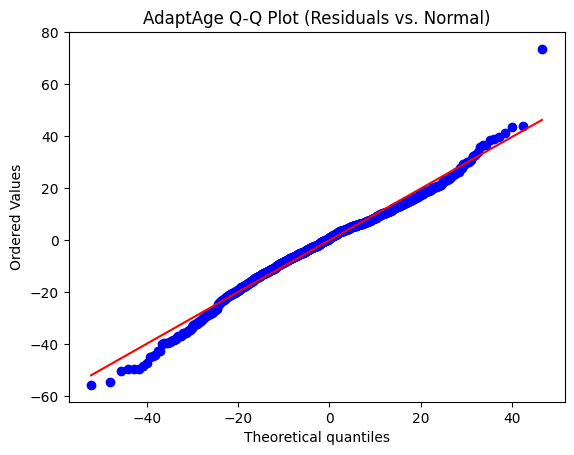

In [256]:
residuals=h_meta.AdaptAge-h_meta.age

# Fit Normal distribution parameters
params_norm = stats.norm.fit(residuals)
mu, std = params_norm


stats.probplot(residuals, dist="norm", sparams=params_norm, plot=plt)
plt.title('AdaptAge Q-Q Plot (Residuals vs. Normal)')

alpha = 0.05  # Significance level (two-tailed)

cutoff_lower = round(stats.norm.ppf(alpha / 2, loc=mu, scale=std),1)
cutoff_upper = round(stats.norm.ppf(1 - alpha / 2, loc=mu, scale=std),1)
mean = round(residuals.mean(),1)


model_stats+=[('AdaptAge',cutoff_lower, cutoff_upper, mean)]
print('p<0.05 Thresholds for fitted Normal distribution: ')
print('Mean error: {:.2f} years' .format(residuals.mean()))
print('Lower: {:.2f} years' .format(cutoff_lower))
print('Upper: {:.2f} years' .format(cutoff_upper))
# plt.savefig('DuoAge/Supp fig 1/Adapt QQ.png',dpi=300)

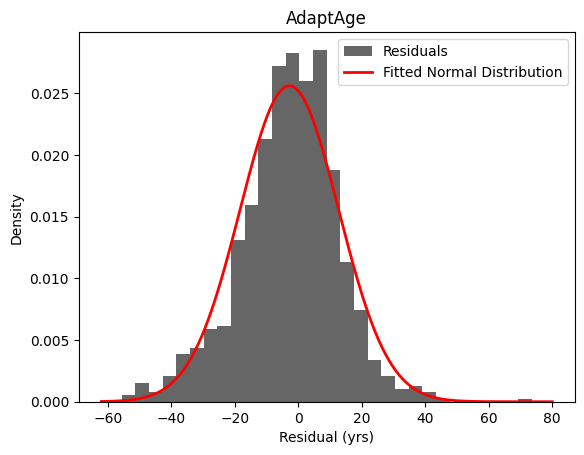

In [257]:
# Create a histogram of residuals
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='k', label='Residuals')

# Create PDFs (probability density functions) of the fitted distributions
xmin, xmax = plt.xlim()
adapt_x = np.linspace(xmin, xmax, 1000)
adapt_resids = stats.norm.pdf(adapt_x, mu, std)

adapt_fit = pd.DataFrame({'Error': adapt_x, 'Density': adapt_resids, 'Model': 'AdaptAge'})

# Plot the fitted distributions
plt.plot(adapt_x, adapt_resids, 'r-', linewidth=2, label='Fitted Normal Distribution')

plt.xlabel('Residual (yrs)')
plt.ylabel('Density')
plt.legend()
plt.title('AdaptAge')
plt.savefig('DuoAge/Supp fig 1/Adapt hist.png',dpi=300)

p<0.05 Thresholds for fitted Normal distribution: 
Mean error: -1.45 years
Lower: -30.70 years
Upper: 27.80 years


Text(0.5, 1.0, 'AdaptAge on Inmflammaging')

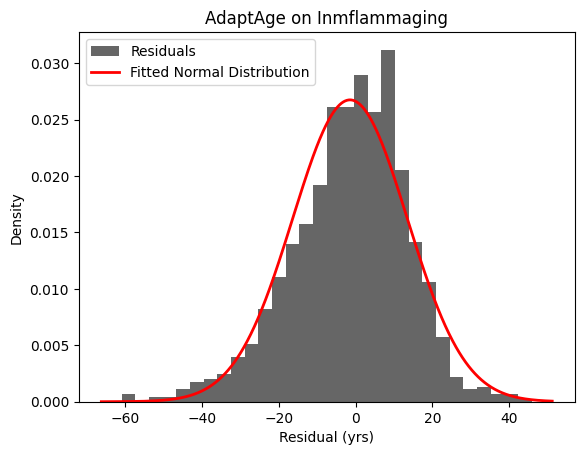

In [258]:
residuals=d_meta.AdaptAge-d_meta.age

# Fit Normal distribution parameters
params_norm = stats.norm.fit(residuals)
mu, std = params_norm

alpha = 0.05  # Significance level (two-tailed)

cutoff_lower = round(stats.norm.ppf(alpha / 2, loc=mu, scale=std),1)
cutoff_upper = round(stats.norm.ppf(1 - alpha / 2, loc=mu, scale=std),1)
mean = round(residuals.mean(),1)

d_model_stats+=[('AdaptAge',cutoff_lower, cutoff_upper, mean)]
print('p<0.05 Thresholds for fitted Normal distribution: ')
print('Mean error: {:.2f} years' .format(residuals.mean()))
print('Lower: {:.2f} years' .format(cutoff_lower))
print('Upper: {:.2f} years' .format(cutoff_upper))

# Create a histogram of residuals
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='k', label='Residuals')

# Create PDFs (probability density functions) of the fitted distributions
xmin, xmax = plt.xlim()
adapt_x = np.linspace(xmin, xmax, 1000)
d_adapt_resids = stats.norm.pdf(adapt_x, mu, std)

d_adapt_fit = pd.DataFrame({'Error': adapt_x, 'Density': d_adapt_resids, 'Model': 'AdaptAge'})

# Plot the fitted distributions
plt.plot(adapt_x, d_adapt_resids, 'r-', linewidth=2, label='Fitted Normal Distribution')

plt.xlabel('Residual (yrs)')
plt.ylabel('Density')
plt.legend()
plt.title('AdaptAge on Inmflammaging')

# DamAge

In [259]:
dam = pd.read_csv('Models/damAge/damAge.csv')
dam=prep_dataset(dam)
# dam_corrs, missing = model_corrs(dam, h_dam, h_meta)
# dam_corrs['importance'] = normalized_importance(dam_corrs, 'damAge')
# sns.scatterplot(data=dam_corrs, x='importance', y='R2')
# dam_corrs['het_rs'] = het_r(h_dam, dam, h_meta.age)
# intersect = list(set(h_comb.columns)&set(dam.CpG))
# intersect.sort()
# d_dam = d_comb[intersect]
# h_dam = h_comb[intersect]
h_dam = pd.read_pickle('Models/damAge/Healthy.pkl')
d_dam = pd.read_pickle('Models/damAge/Disease.pkl')

In [260]:
h_meta.loc[:, 'DamAge'] = get_preds(h_dam, dam)
d_meta.loc[:, 'DamAge'] = get_preds(d_dam, dam)

<AxesSubplot: xlabel='age', ylabel='DamAge'>

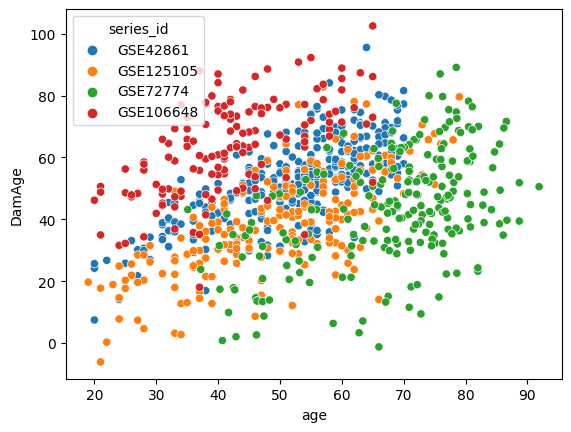

In [261]:
sns.scatterplot(data=h_meta, x='age',y='DamAge',hue='series_id')

p<0.05 Thresholds for fitted Normal distribution: 
Mean error: -5.16 years
Lower: -42.60 years
Upper: 32.30 years


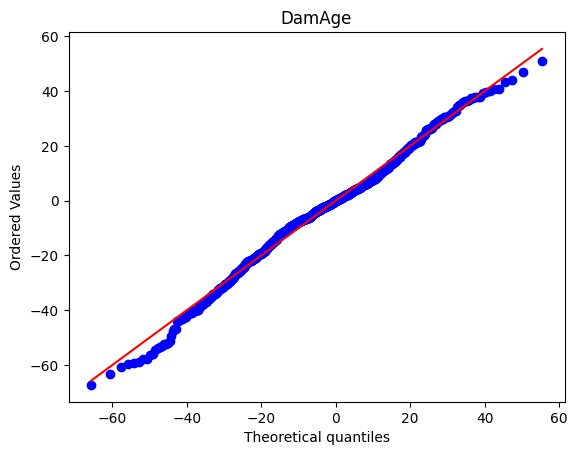

In [262]:
residuals=h_meta.DamAge-h_meta.age

# Fit Normal distribution parameters
params_norm = stats.norm.fit(residuals)
mu, std = params_norm

stats.probplot(residuals, dist="norm", sparams=params_norm, plot=plt)
plt.title('DamAge')

alpha = 0.05  # Significance level (two-tailed)

cutoff_lower = round(stats.norm.ppf(alpha / 2, loc=mu, scale=std),1)
cutoff_upper = round(stats.norm.ppf(1 - alpha / 2, loc=mu, scale=std),1)
mean = round(residuals.mean(),1)


model_stats+=[('DamAge',cutoff_lower, cutoff_upper, mean)]
print('p<0.05 Thresholds for fitted Normal distribution: ')
print('Mean error: {:.2f} years' .format(residuals.mean()))
print('Lower: {:.2f} years' .format(cutoff_lower))
print('Upper: {:.2f} years' .format(cutoff_upper))
# plt.savefig('DuoAge/Supp fig 1/Dam QQ.png',dpi=300)

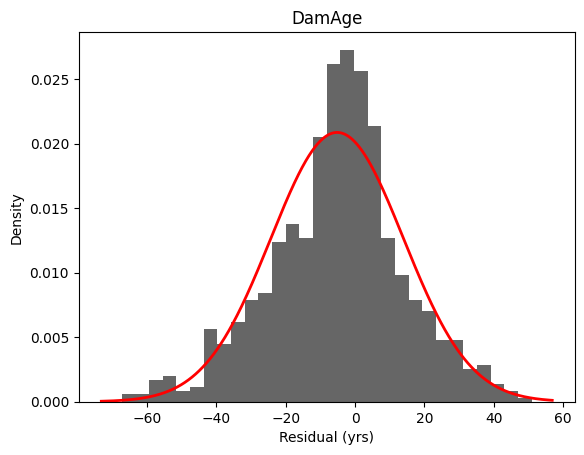

In [263]:
# Create a histogram of residuals
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='k', label='Residuals')

# Create PDFs (probability density functions) of the fitted distributions
xmin, xmax = plt.xlim()
dam_x = np.linspace(xmin, xmax, 1000)
dam_resids = stats.norm.pdf(dam_x, mu, std)

dam_fit = pd.DataFrame({'Error': dam_x, 'Density': dam_resids, 'Model': 'DamAge'})

# Plot the fitted distributions
plt.plot(dam_x, dam_resids, 'r-', linewidth=2, label='Fitted Normal Distribution')

plt.xlabel('Residual (yrs)')
plt.ylabel('Density')
plt.title('DamAge')
plt.savefig('DuoAge/Supp fig 1/Dam hist.png',dpi=300)

p<0.05 Thresholds for fitted Normal distribution: 
Mean error: -6.64 years
Lower: -42.10 years
Upper: 28.80 years


Text(0.5, 1.0, 'DamAge on Inmflammaging')

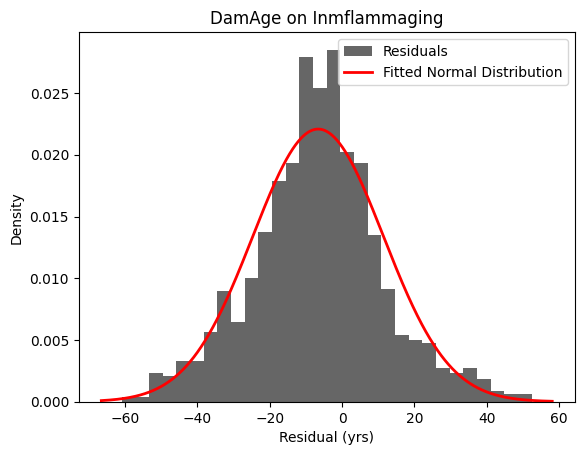

In [264]:
residuals=d_meta.DamAge-d_meta.age

# Fit Normal distribution parameters
params_norm = stats.norm.fit(residuals)
mu, std = params_norm

alpha = 0.05  # Significance level (two-tailed)

cutoff_lower = round(stats.norm.ppf(alpha / 2, loc=mu, scale=std),1)
cutoff_upper = round(stats.norm.ppf(1 - alpha / 2, loc=mu, scale=std),1)
mean = round(residuals.mean(),1)

d_model_stats+=[('DamAge',cutoff_lower, cutoff_upper, mean)]
print('p<0.05 Thresholds for fitted Normal distribution: ')
print('Mean error: {:.2f} years' .format(residuals.mean()))
print('Lower: {:.2f} years' .format(cutoff_lower))
print('Upper: {:.2f} years' .format(cutoff_upper))

# Create a histogram of residuals
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='k', label='Residuals')

# Create PDFs (probability density functions) of the fitted distributions
xmin, xmax = plt.xlim()
Dam_x = np.linspace(xmin, xmax, 1000)
d_Dam_resids = stats.norm.pdf(Dam_x, mu, std)

d_Dam_fit = pd.DataFrame({'Error': Dam_x, 'Density': d_Dam_resids, 'Model': 'DamAge'})

# Plot the fitted distributions
plt.plot(Dam_x, d_Dam_resids, 'r-', linewidth=2, label='Fitted Normal Distribution')

plt.xlabel('Residual (yrs)')
plt.ylabel('Density')
plt.legend()
plt.title('DamAge on Inmflammaging')

# CausAge

In [265]:
caus = pd.read_csv('Models/causAge/causAge.csv')
caus=prep_dataset(caus)
# intersect = list(set(h_comb.columns)&set(caus.CpG[1:]))
# intersect.sort()
# d_caus = d_comb[intersect]
# h_caus = h_comb[intersect]
# caus_corrs, missing = model_corrs(caus, h_caus, h_meta)
# caus_corrs['importance'] = normalized_importance(caus_corrs, 'causAge')
# sns.scatterplot(data=caus_corrs, x='importance', y='R2')
# caus_corrs['het_rs'] = het_r(h_caus, caus, h_meta.age)
# h_caus.to_pickle('Models/CausAge/Healthy.pkl')
# d_caus.to_pickle('Models/CausAge/Disease.pkl')
# caus_corrs.to_excel('Models/CausAge/stats.xlsx')
h_caus = pd.read_pickle('Models/CausAge/Healthy.pkl')
d_caus = pd.read_pickle('Models/CausAge/Disease.pkl')

In [266]:
h_meta.loc[:, 'CausAge'] = get_preds(h_caus, caus)
d_meta.loc[:, 'CausAge'] = get_preds(d_caus, caus)

<AxesSubplot: xlabel='age', ylabel='CausAge'>

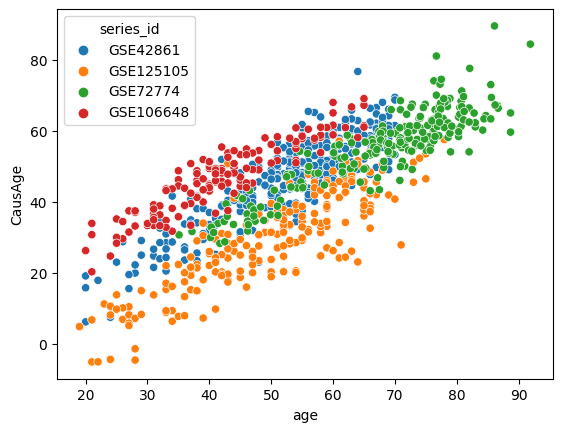

In [267]:
sns.scatterplot(data=h_meta, x='age',y='CausAge',hue='series_id')

p<0.05 Thresholds for fitted Normal distribution: 
Mean error: -9.29 years
Lower: -29.00 years
Upper: 10.40 years


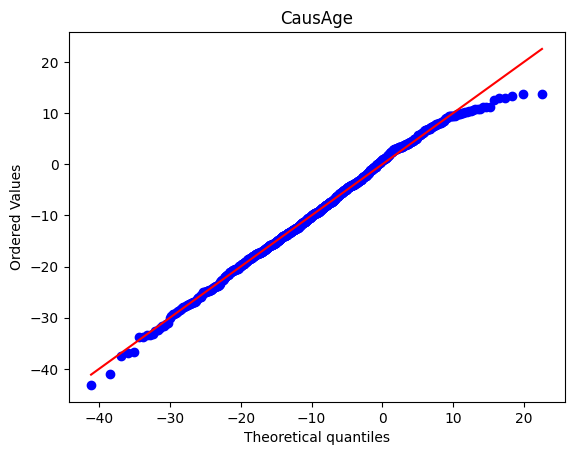

In [268]:
residuals=h_meta.CausAge-h_meta.age

# Fit Normal distribution parameters
params_norm = stats.norm.fit(residuals)
mu, std = params_norm


# Q-Q Plot for Normal Distribution

stats.probplot(residuals, dist="norm", sparams=params_norm, plot=plt)
plt.title('CausAge')

alpha = 0.05  # Significance level (two-tailed)

cutoff_lower = round(stats.norm.ppf(alpha / 2, loc=mu, scale=std),1)
cutoff_upper = round(stats.norm.ppf(1 - alpha / 2, loc=mu, scale=std),1)
mean = round(residuals.mean(),1)


model_stats+=[('CausAge',cutoff_lower, cutoff_upper, mean)]
print('p<0.05 Thresholds for fitted Normal distribution: ')
print('Mean error: {:.2f} years' .format(residuals.mean()))
print('Lower: {:.2f} years' .format(cutoff_lower))
print('Upper: {:.2f} years' .format(cutoff_upper))
plt.savefig('DuoAge/Supp fig 1/Caus QQ.png',dpi=300)

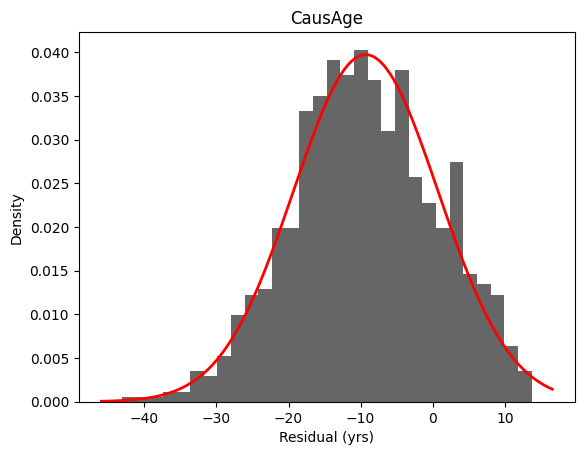

In [269]:
# Create a histogram of residuals
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='k', label='Residuals')

# Create PDFs (probability density functions) of the fitted distributions
xmin, xmax = plt.xlim()
caus_x = np.linspace(xmin, xmax, 1000)
caus_resids = stats.norm.pdf(caus_x, mu, std)

caus_fit = pd.DataFrame({'Error': caus_x, 'Density': caus_resids, 'Model': 'CausAge'})

# Plot the fitted distributions
plt.plot(caus_x, caus_resids, 'r-', linewidth=2, label='Fitted Normal Distribution')

plt.xlabel('Residual (yrs)')
plt.ylabel('Density')
plt.title('CausAge')
plt.savefig('DuoAge/Supp fig 1/Caus hist.png',dpi=300)

p<0.05 Thresholds for fitted Normal distribution: 
Mean error: -12.03 years
Lower: -32.20 years
Upper: 8.20 years


Text(0.5, 1.0, 'CausAge on Inmflammaging')

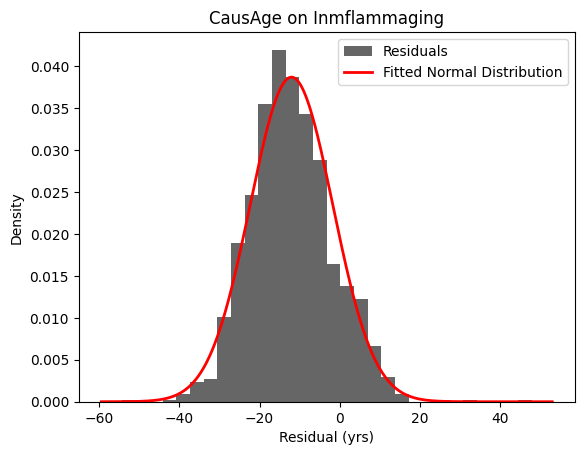

In [270]:
residuals=d_meta.CausAge-d_meta.age

# Fit Normal distribution parameters
params_norm = stats.norm.fit(residuals)
mu, std = params_norm

alpha = 0.05  # Significance level (two-tailed)

cutoff_lower = round(stats.norm.ppf(alpha / 2, loc=mu, scale=std),1)
cutoff_upper = round(stats.norm.ppf(1 - alpha / 2, loc=mu, scale=std),1)
mean = round(residuals.mean(),1)

d_model_stats+=[('CausAge',cutoff_lower, cutoff_upper, mean)]
print('p<0.05 Thresholds for fitted Normal distribution: ')
print('Mean error: {:.2f} years' .format(residuals.mean()))
print('Lower: {:.2f} years' .format(cutoff_lower))
print('Upper: {:.2f} years' .format(cutoff_upper))

# Create a histogram of residuals
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='k', label='Residuals')

# Create PDFs (probability density functions) of the fitted distributions
xmin, xmax = plt.xlim()
Caus_x = np.linspace(xmin, xmax, 1000)
d_Caus_resids = stats.norm.pdf(Caus_x, mu, std)

d_Caus_fit = pd.DataFrame({'Error': Caus_x, 'Density': d_Caus_resids, 'Model': 'CausAge'})

# Plot the fitted distributions
plt.plot(Caus_x, d_Caus_resids, 'r-', linewidth=2, label='Fitted Normal Distribution')

plt.xlabel('Residual (yrs)')
plt.ylabel('Density')
plt.legend()
plt.title('CausAge on Inmflammaging')

# Hannum

In [1]:
hannum = pd.read_excel('Models/hannum/Hannum model.xlsx')
hannum=prep_dataset(hannum)
# hannum_corrs, missing = model_corrs(hannum, h_hannum, h_meta)
# hannum_corrs['importance'] = normalized_importance(hannum_corrs, 'hannum')
# # sns.scatterplot(data=hannum_corrs, x='importance', y='R2')
# hannum_corrs['het_rs'] = het_r(h_hannum, hannum, h_meta.age)
# # intersect = list(set(h_comb.columns)&set(hannum.CpG))
# # intersect.sort()
# # d_hannum = d_comb[intersect]
# # h_hannum = h_comb[intersect]
h_hannum = pd.read_pickle('Models/hannum/Healthy.pkl')
d_hannum = pd.read_pickle('Models/hannum/Disease.pkl')

NameError: name 'pd' is not defined

In [272]:
h_meta.loc[:, 'Hannum'] = get_preds(h_hannum, hannum)
d_meta.loc[:, 'Hannum'] = get_preds(d_hannum, hannum)

<AxesSubplot: xlabel='age', ylabel='Hannum'>

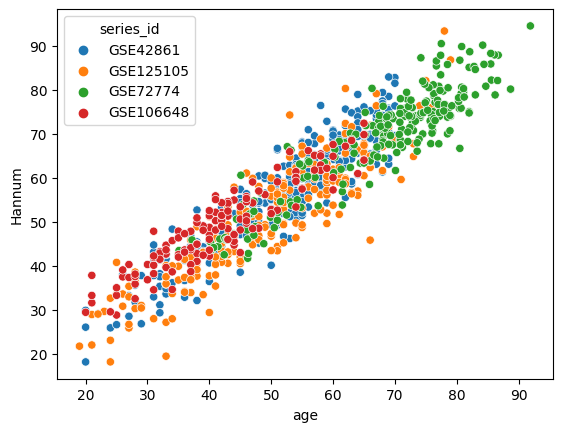

In [273]:
sns.scatterplot(data=h_meta, x='age',y='Hannum',hue='series_id')

p<0.05 Thresholds for fitted Normal distribution: 
Mean error: 3.69 years
Lower: -7.10 years
Upper: 14.50 years


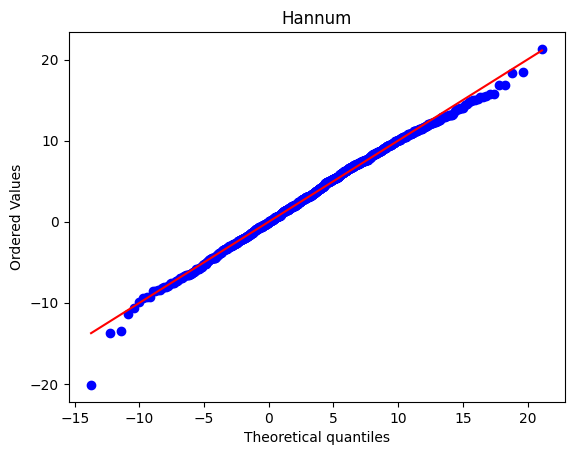

In [274]:
residuals=h_meta.Hannum-h_meta.age

# Fit Normal distribution parameters
params_norm = stats.norm.fit(residuals)
mu, std = params_norm


# Q-Q Plot for Normal Distribution

stats.probplot(residuals, dist="norm", sparams=params_norm, plot=plt)
plt.title('Hannum')

alpha = 0.05  # Significance level (two-tailed)

cutoff_lower = round(stats.norm.ppf(alpha / 2, loc=mu, scale=std),1)
cutoff_upper = round(stats.norm.ppf(1 - alpha / 2, loc=mu, scale=std),1)
mean = round(residuals.mean(),1)


model_stats+=[('Hannum',cutoff_lower, cutoff_upper, mean)]
print('p<0.05 Thresholds for fitted Normal distribution: ')
print('Mean error: {:.2f} years' .format(residuals.mean()))
print('Lower: {:.2f} years' .format(cutoff_lower))
print('Upper: {:.2f} years' .format(cutoff_upper))
# plt.savefig('DuoAge/Supp fig 1/Hannum QQ.png',dpi=300)

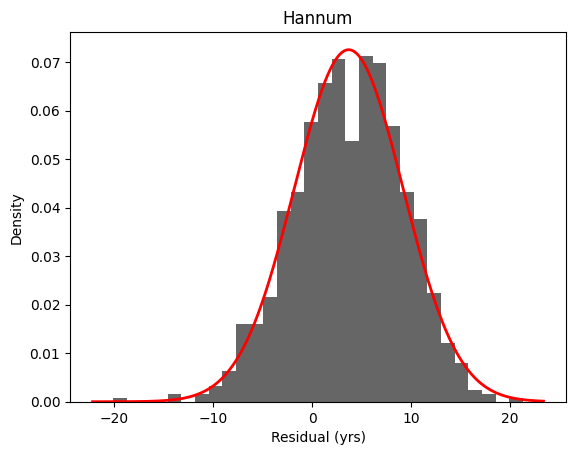

In [275]:
# Create a histogram of residuals
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='k', label='Residuals')

# Create PDFs (probability density functions) of the fitted distributions
xmin, xmax = plt.xlim()
hannum_x = np.linspace(xmin, xmax, 1000)
hannum_resids = stats.norm.pdf(hannum_x, mu, std)

hannum_fit = pd.DataFrame({'Error': hannum_x, 'Density': hannum_resids, 'Model': 'Hannum'})

# Plot the fitted distributions
plt.plot(hannum_x, hannum_resids, 'r-', linewidth=2, label='Fitted Normal Distribution')

plt.xlabel('Residual (yrs)')
plt.ylabel('Density')
plt.title('Hannum')
plt.savefig('DuoAge/Supp fig 1/Hannum hist.png',dpi=300)

p<0.05 Thresholds for fitted Normal distribution: 
Mean error: 3.93 years
Lower: -7.90 years
Upper: 15.80 years


Text(0.5, 1.0, 'Hannum on Inmflammaging')

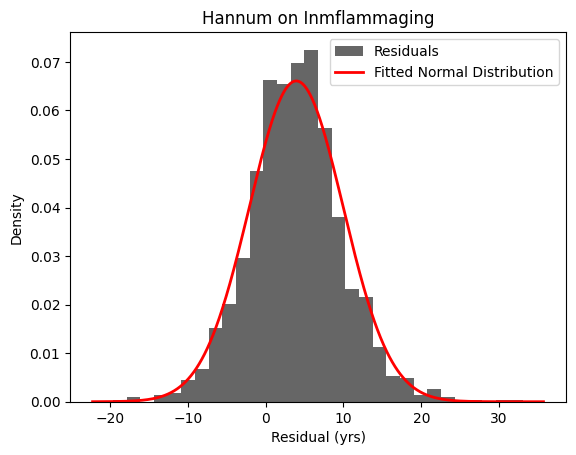

In [276]:
residuals=d_meta.Hannum-d_meta.age

# Fit Normal distribution parameters
params_norm = stats.norm.fit(residuals)
mu, std = params_norm

alpha = 0.05  # Significance level (two-tailed)

cutoff_lower = round(stats.norm.ppf(alpha / 2, loc=mu, scale=std),1)
cutoff_upper = round(stats.norm.ppf(1 - alpha / 2, loc=mu, scale=std),1)
mean = round(residuals.mean(),1)

d_model_stats+=[('Hannum',cutoff_lower, cutoff_upper, mean)]
print('p<0.05 Thresholds for fitted Normal distribution: ')
print('Mean error: {:.2f} years' .format(residuals.mean()))
print('Lower: {:.2f} years' .format(cutoff_lower))
print('Upper: {:.2f} years' .format(cutoff_upper))

# Create a histogram of residuals
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='k', label='Residuals')

# Create PDFs (probability density functions) of the fitted distributions
xmin, xmax = plt.xlim()
hannum_x = np.linspace(xmin, xmax, 1000)
d_hannum_resids = stats.norm.pdf(hannum_x, mu, std)

d_hannum_fit = pd.DataFrame({'Error': hannum_x, 'Density': d_hannum_resids, 'Model': 'Hannum'})

# Plot the fitted distributions
plt.plot(hannum_x, d_hannum_resids, 'r-', linewidth=2, label='Fitted Normal Distribution')

plt.xlabel('Residual (yrs)')
plt.ylabel('Density')
plt.legend()
plt.title('Hannum on Inmflammaging')

# Horvath

In [277]:
horvath = pd.read_excel('Models/Horvath/Horvath model.xlsx')
horvath = prep_dataset(horvath)
# horvath_corrs, missing = model_corrs(horvath, h_horvath, h_meta)
# horvath_corrs['importance'] = normalized_importance(horvath_corrs, 'horvath')
# # sns.scatterplot(data=horvath_corrs, x='importance', y='R2')
# horvath_corrs['het_rs'] = het_r(h_horvath, horvath, h_meta.age)
# intersect = list(set(h_comb.columns)&set(horvath.CpG))
# intersect.sort()
# d_horvath = d_comb[intersect]
# h_horvath = h_comb[intersect]
h_horvath = pd.read_pickle('Models/horvath/Healthy.pkl')
d_horvath = pd.read_pickle('Models/horvath/Disease.pkl')

In [278]:
h_meta.loc[:, 'Horvath'] = get_horvath(h_horvath, horvath)
d_meta.loc[:, 'Horvath'] = get_horvath(d_horvath, horvath)

<AxesSubplot: xlabel='age', ylabel='Horvath'>

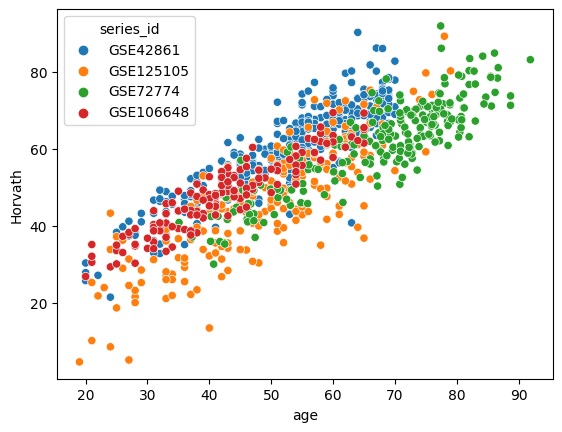

In [279]:
sns.scatterplot(data=h_meta, x='age',y='Horvath',hue='series_id')

p<0.05 Thresholds for fitted Normal distribution: 
Mean error: 1.43 years
Lower: -15.10 years
Upper: 18.00 years


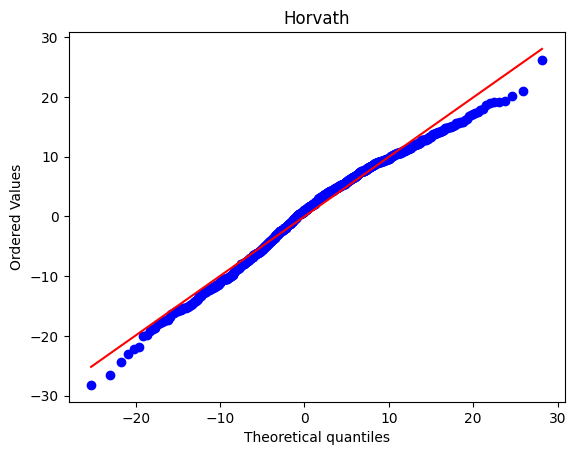

In [280]:
residuals=h_meta.Horvath-h_meta.age

# Fit Normal distribution parameters
params_norm = stats.norm.fit(residuals)
mu, std = params_norm

# Q-Q Plot for Normal Distribution

stats.probplot(residuals, dist="norm", sparams=params_norm, plot=plt)
plt.title('Horvath')

alpha = 0.05  # Significance level (two-tailed)

cutoff_lower = round(stats.norm.ppf(alpha / 2, loc=mu, scale=std),1)
cutoff_upper = round(stats.norm.ppf(1 - alpha / 2, loc=mu, scale=std),1)
mean = round(residuals.mean(),1)


model_stats+=[('Horvath',cutoff_lower, cutoff_upper, mean)]
print('p<0.05 Thresholds for fitted Normal distribution: ')
print('Mean error: {:.2f} years' .format(residuals.mean()))
print('Lower: {:.2f} years' .format(cutoff_lower))
print('Upper: {:.2f} years' .format(cutoff_upper))
# plt.savefig('DuoAge/Supp fig 1/Horvath QQ.png',dpi=300)

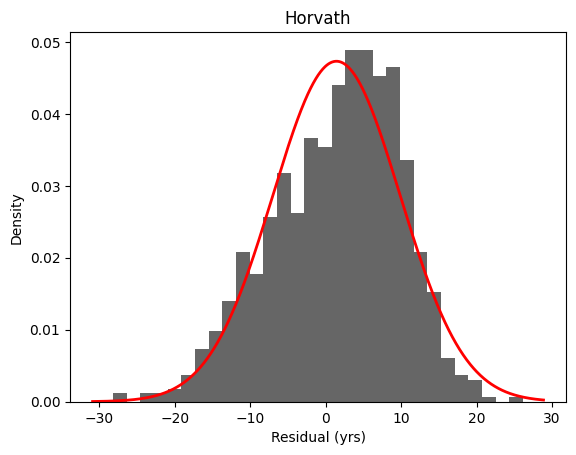

In [281]:
# Create a histogram of residuals
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='k', label='Residuals')

# Create PDFs (probability density functions) of the fitted distributions
xmin, xmax = plt.xlim()
horvath_x = np.linspace(xmin, xmax, 1000)
horvath_resids = stats.norm.pdf(horvath_x, mu, std)

horvath_fit = pd.DataFrame({'Error': horvath_x, 'Density': horvath_resids, 'Model': 'Horvath'})

# Plot the fitted distributions
plt.plot(horvath_x, horvath_resids, 'r-', linewidth=2, label='Fitted Normal Distribution')

plt.xlabel('Residual (yrs)')
plt.ylabel('Density')
plt.title('Horvath')
plt.savefig('DuoAge/Supp fig 1/Horvath hist.png',dpi=300)

p<0.05 Thresholds for fitted Normal distribution: 
Mean error: 0.06 years
Lower: -16.50 years
Upper: 16.70 years


Text(0.5, 1.0, 'Horvath on Inmflammaging')

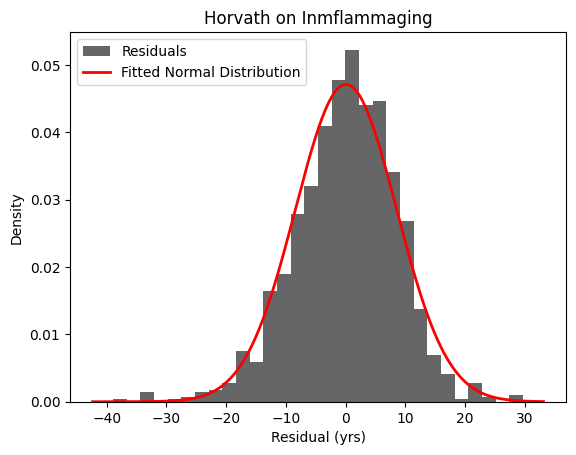

In [282]:
residuals=d_meta.Horvath-d_meta.age

# Fit Normal distribution parameters
params_norm = stats.norm.fit(residuals)
mu, std = params_norm

alpha = 0.05  # Significance level (two-tailed)

cutoff_lower = round(stats.norm.ppf(alpha / 2, loc=mu, scale=std),1)
cutoff_upper = round(stats.norm.ppf(1 - alpha / 2, loc=mu, scale=std),1)
mean = round(residuals.mean(),1)

d_model_stats+=[('Horvath',cutoff_lower, cutoff_upper, mean)]
print('p<0.05 Thresholds for fitted Normal distribution: ')
print('Mean error: {:.2f} years' .format(residuals.mean()))
print('Lower: {:.2f} years' .format(cutoff_lower))
print('Upper: {:.2f} years' .format(cutoff_upper))

# Create a histogram of residuals
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='k', label='Residuals')

# Create PDFs (probability density functions) of the fitted distributions
xmin, xmax = plt.xlim()
horvath_x = np.linspace(xmin, xmax, 1000)
d_horvath_resids = stats.norm.pdf(horvath_x, mu, std)

d_horvath_fit = pd.DataFrame({'Error': horvath_x, 'Density': d_horvath_resids, 'Model': 'Horvath'})

# Plot the fitted distributions
plt.plot(horvath_x, d_horvath_resids, 'r-', linewidth=2, label='Fitted Normal Distribution')

plt.xlabel('Residual (yrs)')
plt.ylabel('Density')
plt.legend()
plt.title('Horvath on Inmflammaging')

In [283]:
model_stats

[('AdaptAge', -33.4, 27.7, -2.8),
 ('DamAge', -42.6, 32.3, -5.2),
 ('CausAge', -29.0, 10.4, -9.3),
 ('Hannum', -7.1, 14.5, 3.7),
 ('Horvath', -15.1, 18.0, 1.4)]

In [284]:
d_model_stats

[('AdaptAge', -30.7, 27.8, -1.5),
 ('DamAge', -42.1, 28.8, -6.6),
 ('CausAge', -32.2, 8.2, -12.0),
 ('Hannum', -7.9, 15.8, 3.9),
 ('Horvath', -16.5, 16.7, 0.1)]

# PhenoAge

In [285]:
pheno = pd.read_excel('Models/Phenoage/Phenoage model.xlsx')
pheno=prep_dataset(pheno)
# phenoage_corrs, missing = model_corrs(phenoage, h_phenoage, h_meta)
# phenoage_corrs['importance'] = normalized_importance(phenoage_corrs, 'phenoage')
# # sns.scatterplot(data=phenoage_corrs, x='importance', y='R2')
# phenoage_corrs['het_rs'] = het_r(h_phenoage, phenoage, h_meta.age)
# intersect = list(set(h_comb.columns)&set(phenoage.CpG))
# intersect.sort()
# d_phenoage = d_comb[intersect]
# h_phenoage = h_comb[intersect]
h_pheno = pd.read_pickle('Models/phenoAge/Healthy.pkl')
d_pheno = pd.read_pickle('Models/phenoAge/Disease.pkl')

In [286]:
h_meta.loc[:, 'PhenoAge'] = get_preds(h_pheno, pheno)
d_meta.loc[:, 'PhenoAge'] = get_preds(d_pheno, pheno)

<AxesSubplot: xlabel='age', ylabel='PhenoAge'>

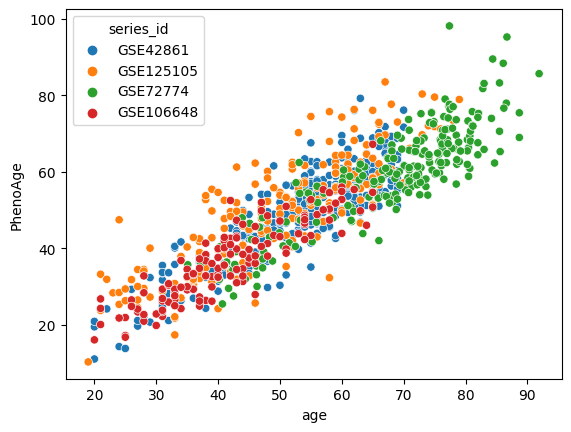

In [287]:
sns.scatterplot(data=h_meta, x='age',y='PhenoAge',hue='series_id')

p<0.05 Thresholds for fitted Normal distribution: 
Mean error: -4.25 years
Lower: -18.30 years
Upper: 9.80 years


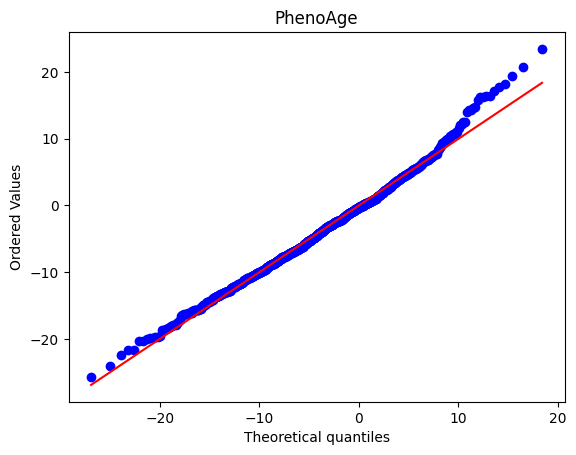

In [288]:
residuals=h_meta.PhenoAge-h_meta.age

# Fit Normal distribution parameters
params_norm = stats.norm.fit(residuals)
mu, std = params_norm

# Q-Q Plot for Normal Distribution

stats.probplot(residuals, dist="norm", sparams=params_norm, plot=plt)
plt.title('PhenoAge')

alpha = 0.05  # Significance level (two-tailed)

cutoff_lower = round(stats.norm.ppf(alpha / 2, loc=mu, scale=std),1)
cutoff_upper = round(stats.norm.ppf(1 - alpha / 2, loc=mu, scale=std),1)
mean = round(residuals.mean(),1)

model_stats+=[('PhenoAge',cutoff_lower, cutoff_upper, mean)]
print('p<0.05 Thresholds for fitted Normal distribution: ')
print('Mean error: {:.2f} years' .format(residuals.mean()))
print('Lower: {:.2f} years' .format(cutoff_lower))
print('Upper: {:.2f} years' .format(cutoff_upper))
# plt.savefig('DuoAge/Supp fig 1/Pheno QQ.png',dpi=300)

Text(0.5, 1.0, 'PhenoAge')

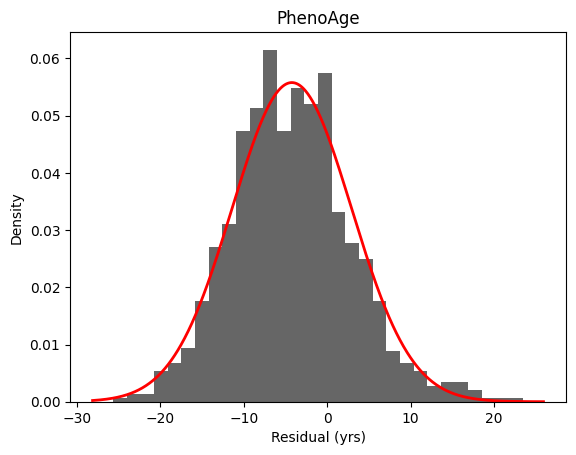

In [289]:
# Create a histogram of residuals
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='k', label='Residuals')

# Create PDFs (probability density functions) of the fitted distributions
xmin, xmax = plt.xlim()
pheno_x = np.linspace(xmin, xmax, 1000)
pheno_resids = stats.norm.pdf(pheno_x, mu, std)

pheno_fit = pd.DataFrame({'Error': pheno_x, 'Density': pheno_resids, 'Model': 'PhenoAge'})

# Plot the fitted distributions
plt.plot(pheno_x, pheno_resids, 'r-', linewidth=2, label='Fitted Normal Distribution')

plt.xlabel('Residual (yrs)')
plt.ylabel('Density')
plt.title('PhenoAge')
# plt.savefig('DuoAge/Supp fig 1/Pheno hist.png',dpi=300)

p<0.05 Thresholds for fitted Normal distribution: 
Mean error: -1.53 years
Lower: -18.10 years
Upper: 15.00 years


Text(0.5, 1.0, 'PhenoAge on Inmflammaging')

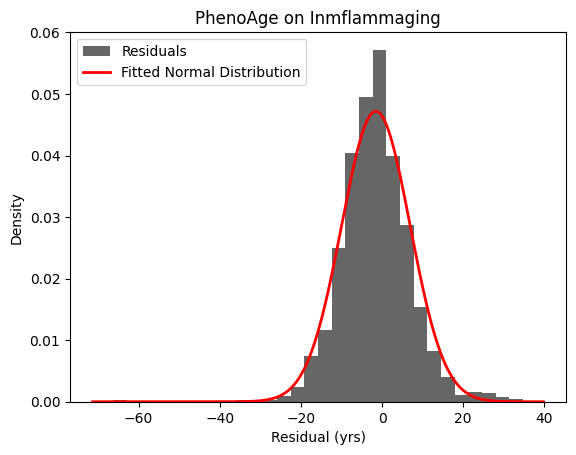

In [290]:
residuals=d_meta.PhenoAge-d_meta.age

# Fit Normal distribution parameters
params_norm = stats.norm.fit(residuals)
mu, std = params_norm

alpha = 0.05  # Significance level (two-tailed)

cutoff_lower = round(stats.norm.ppf(alpha / 2, loc=mu, scale=std),1)
cutoff_upper = round(stats.norm.ppf(1 - alpha / 2, loc=mu, scale=std),1)
mean = round(residuals.mean(),1)

d_model_stats+=[('PhenoAge',cutoff_lower, cutoff_upper, mean)]
print('p<0.05 Thresholds for fitted Normal distribution: ')
print('Mean error: {:.2f} years' .format(residuals.mean()))
print('Lower: {:.2f} years' .format(cutoff_lower))
print('Upper: {:.2f} years' .format(cutoff_upper))

# Create a histogram of residuals
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='k', label='Residuals')

# Create PDFs (probability density functions) of the fitted distributions
xmin, xmax = plt.xlim()
pheno_x = np.linspace(xmin, xmax, 1000)
d_pheno_resids = stats.norm.pdf(pheno_x, mu, std)

d_pheno_fit = pd.DataFrame({'Error': pheno_x, 'Density': d_pheno_resids, 'Model': 'PhenoAge'})

# Plot the fitted distributions
plt.plot(pheno_x, d_pheno_resids, 'r-', linewidth=2, label='Fitted Normal Distribution')

plt.xlabel('Residual (yrs)')
plt.ylabel('Density')
plt.legend()
plt.title('PhenoAge on Inmflammaging')

In [291]:
model_stats

[('AdaptAge', -33.4, 27.7, -2.8),
 ('DamAge', -42.6, 32.3, -5.2),
 ('CausAge', -29.0, 10.4, -9.3),
 ('Hannum', -7.1, 14.5, 3.7),
 ('Horvath', -15.1, 18.0, 1.4),
 ('PhenoAge', -18.3, 9.8, -4.3)]

In [292]:
d_model_stats

[('AdaptAge', -30.7, 27.8, -1.5),
 ('DamAge', -42.1, 28.8, -6.6),
 ('CausAge', -32.2, 8.2, -12.0),
 ('Hannum', -7.9, 15.8, 3.9),
 ('Horvath', -16.5, 16.7, 0.1),
 ('PhenoAge', -18.1, 15.0, -1.5)]

In [293]:
cutoffs = pd.DataFrame(model_stats, columns=['Model', 'Lower cutoff (p<0.05)', 'Upper cutoff (p<0.05)', 'Mean error (yr)'])
d_cutoffs = pd.DataFrame(d_model_stats, columns=['Model', 'Lower cutoff (p<0.05)', 'Upper cutoff (p<0.05)', 'Mean error (yr)'])

In [294]:
cutoffs.to_excel('FSWclock/h_model_cutoffs.xlsx')
d_cutoffs.to_excel('FSWclock/d_model_cutoffs.xlsx')

In [295]:
cutoffs

Model  Lower cutoff (p<0.05)  Upper cutoff (p<0.05)  Mean error (yr)
0  AdaptAge                  -33.4                   27.7             -2.8
1    DamAge                  -42.6                   32.3             -5.2
2   CausAge                  -29.0                   10.4             -9.3
3    Hannum                   -7.1                   14.5              3.7
4   Horvath                  -15.1                   18.0              1.4
5  PhenoAge                  -18.3                    9.8             -4.3

# PACE

In [321]:
pace = pd.read_excel('Models/Pace/Pace.xlsx')
pace=prep_dataset(pace)
# pace_corrs, missing = model_corrs(pace, h_pace, h_meta)
# pace_corrs['importance'] = normalized_importance(pace_corrs, 'PACE')
# # sns.scatterplot(data=pace_corrs, x='importance', y='R2')
# pace_corrs['het_rs'] = het_r(h_pace, pace, h_meta.age)
# intersect = list(set(h_comb.columns)&set(pace.CpG))
# intersect.sort()
# d_pace = d_comb[intersect]
# h_pace = h_comb[intersect]
h_pace = pd.read_pickle('Models/pace/Healthy.pkl')
d_pace = pd.read_pickle('Models/pace/Disease.pkl')

In [322]:
h_meta.loc[:, 'PACE'] = get_preds(h_pace, pace)
d_meta.loc[:, 'PACE'] = get_preds(d_pace, pace)

In [323]:
comb_meta = pd.concat([h_meta,d_meta], axis=0)

<AxesSubplot: xlabel='age', ylabel='PACE'>

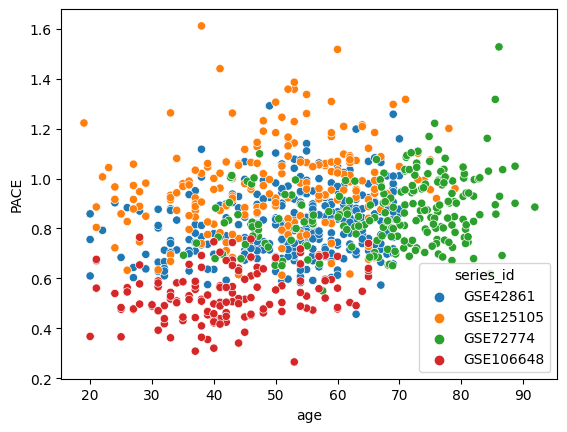

In [29]:
sns.scatterplot(data=h_meta, x='age',y='PACE',hue='series_id')

In [324]:
# Replace values
comb_meta['healthy'] = comb_meta['healthy'].replace({0: 'Control', 1: 'Inflammaging'})

In [240]:
conditions = ['Control', 'Inflammaging']

In [241]:
import matplotlib.lines as mlines
# help(mlines.Line2D)

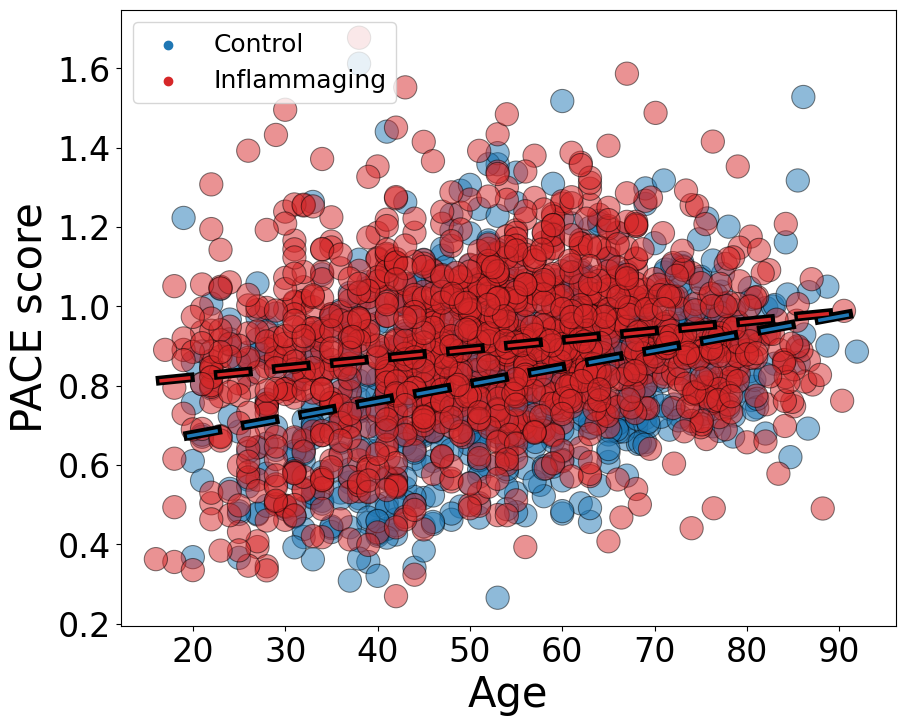

In [243]:
#regress a given predictor on age
regression = stats.linregress(h_meta.age.astype(float), h_meta.PACE.astype(float))
slope, intercept, rvalue, pvalue, stderr = regression
h_preds = slope*h_meta.age+intercept

blue = sns.color_palette()[0]
red=sns.color_palette()[3]

custom= {conditions[0]:blue, conditions[1]:red}

plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(data=comb_meta, x='age', y='PACE',hue='healthy', s=280, palette = custom, alpha = 0.5, 
                edgecolor='k', linewidth=0.75)

sns.regplot(data = comb_meta[comb_meta.healthy=='Control'], x=comb_meta[comb_meta.healthy=='Control'].age+0.38, y='PACE', scatter=False,ci=0, color=blue, 
            line_kws={"linestyle": "--","linewidth":2.5, "dashes":(9, 7.8), "zorder":6})
sns.regplot(data = comb_meta[comb_meta.healthy=='Control'], x='age', y='PACE', scatter=False,ci=0, color='k',
            line_kws={"linestyle": "--","linewidth":7, "dashes":(4, 2), "zorder":5})

sns.regplot(data = comb_meta[comb_meta.healthy!='Control'], x=comb_meta[comb_meta.healthy!='Control'].age+0.38, y='PACE', scatter=False,ci=0, color=red, 
            line_kws={"linestyle": "--","linewidth":2.5, "dashes":(9, 7.8), "zorder":6})
sns.regplot(data = comb_meta[comb_meta.healthy!='Control'], x='age', y='PACE', scatter=False,ci=0, color='k',
            line_kws={"linestyle": "--","linewidth":7, "dashes":(4, 2), "zorder":5})


plt.xlabel('Age',fontsize=30)
plt.ylabel('PACE score',fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=18)
plt.savefig('FSWclock/Figure 2/Pace scores.png',dpi=300)

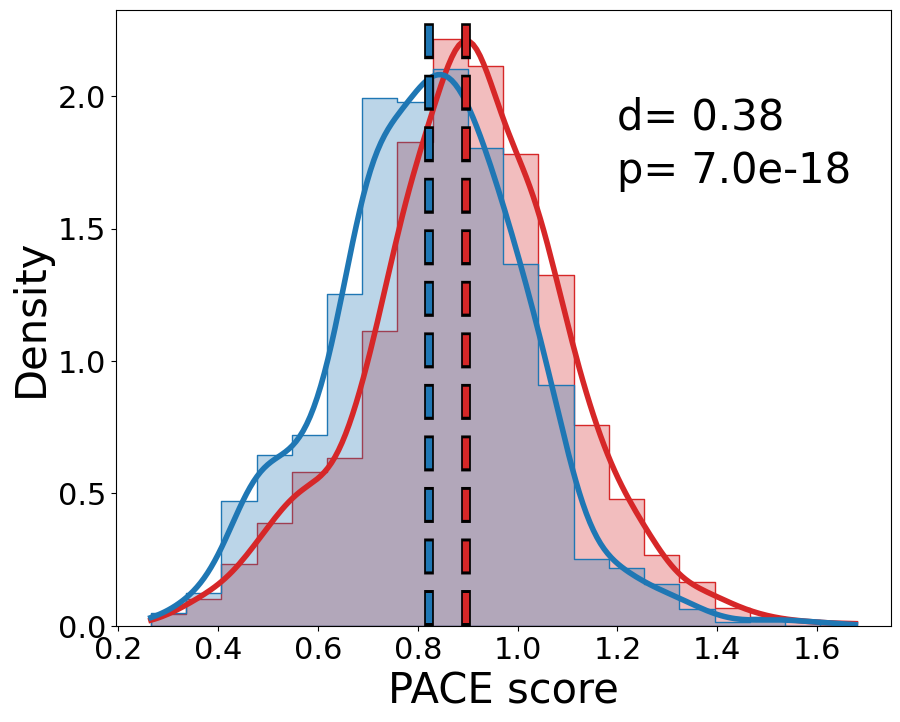

In [526]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
custom= {conditions[0]:blue, conditions[1]:red}

h_scores = comb_meta[comb_meta.healthy=='Control'].PACE
d_scores = comb_meta[comb_meta.healthy=='Inflammaging'].PACE
# Perform the Mann-Whitney U test
# statistic, p_value = mannwhitneyu(h_scores, d_scores)
statistic, p_value = stats.ttest_ind(d_scores, h_scores, equal_var=False)

d = cohens_d(h_scores, d_scores)
plt.text(1.2, 2, f"d= {d:.2f}", fontsize=30, verticalalignment='top')
plt.text(1.2, 1.8, f"p= {p_value:.1e}", fontsize=30, verticalalignment='top')

    
# Define the desired order of categories
sns.histplot(data=comb_meta, x='PACE', kde=True, 
             bins=20, alpha=0.3, hue='healthy',
             element="step",
             stat="density",  # Normalize to percentage
             common_norm=False,  # Ensures separate normalization for each hue level
             legend=False, 
             palette=custom, 
             line_kws={'linewidth': 4})

plt.xlabel('PACE score',fontsize=30)
plt.ylabel('Density',fontsize=30)


# Add vertical lines
plt.axvline(x=d_scores.mean(), color=red, linestyle='--',ymin=0.005, dashes=(4.8, 3.45),linewidth=4.5,zorder=6)
plt.axvline(x=d_scores.mean(), color='k', linestyle='--',linewidth=7)
plt.axvline(x=h_scores.mean(), color=blue, linestyle='--',ymin=0.005, dashes=(4.8, 3.45),linewidth=4.5,zorder=6)
plt.axvline(x=h_scores.mean(), color='k', linestyle='--',linewidth=7)


plt.xticks(fontsize=22);
plt.yticks(fontsize=22);
plt.savefig('FSWclock/Figure 2/Pace scores hist.png',dpi=300)

In [230]:
conditions = ['Control', 'Rheumatoid arthritis']

blue = sns.color_palette()[0]
red=sns.color_palette()[3]

custom_palette = {conditions[0]:blue, conditions[1]:red}

cg='cg03172657' ##up_shift example 
# cg='cg22626683' ##down_shift example

plt.figure(figsize=(8, 6)) 
# Create a scatter plot of the transformed data
sns.scatterplot(x=art_meta.age, y=art[cg] ,hue=art_meta.disease_state, alpha=0.3, s=120, 
                palette =custom_palette, edgecolor='k',legend=False)

sns.regplot(x=art_meta[art_meta.healthy==0].age+0.19, y=art.loc[art_meta.healthy==0][cg], scatter=False,ci=0, color=blue, 
            line_kws={"linestyle": "--","linewidth":5, "dashes":(5.15, 3.24), "zorder":6})
sns.regplot(x=art_meta[art_meta.healthy==0].age, y=art.loc[art_meta.healthy==0][cg], scatter=False,ci=0, color='k',
            line_kws={"linestyle": "--","linewidth":7, "dashes":(4, 2), "zorder":5})

sns.regplot(x=art_meta[art_meta.healthy==1].age+0.19, y=art.loc[art_meta.healthy==1][cg], scatter=False,ci=0, color=red, 
            line_kws={"linestyle": "--","linewidth":5, "dashes":(5.15, 3.24), "zorder":6})
sns.regplot(x=art_meta[art_meta.healthy==1].age, y=art.loc[art_meta.healthy==1][cg], scatter=False,ci=0, color='k',
            line_kws={"linestyle": "--","linewidth":7, "dashes":(4, 2), "zorder":5})



# plt.xlabel('Age',fontsize=34)
plt.xlabel(None) ## use for up_shift plot
plt.ylabel('Beta',fontsize=34)
plt.title(cg, fontsize=20)

plt.xticks([]);
plt.yticks([]);
# plt.savefig('FSWclock/Figure 4/up_shift.png', dpi=300)

NameError: name 'art_meta' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
h_resids = comb_meta[comb_meta.healthy=='Control'].PACE
d_resids = comb_meta[comb_meta.healthy=='Inflammaging'].PACE
# Perform the Welch's t-test (independent t-test with unequal variances)
statistic, p_value = ttest_ind(h_resids, d_resids, equal_var=False)

In [185]:
effect_size = cohens_d(h_resids, d_resids)

In [186]:
effect_size

0.16771372278753247

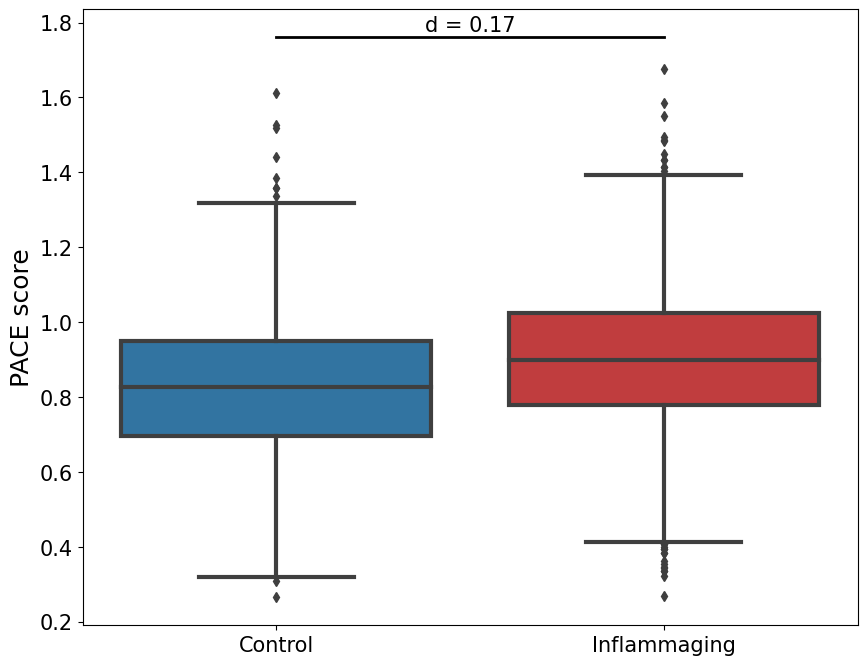

In [188]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]
    
custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.boxplot(data=comb_meta, x='healthy', y='PACE', palette=custom_palette, order=category_order,linewidth=3)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_resids)*(1.05), max(d_resids)*(1.05)], 'k-', lw=2)
plt.text(0.5, max(d_resids)*(1.06), f'd = {effect_size:.2g}', ha='center', fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel(None)
plt.ylabel('PACE score',fontsize=18)
plt.savefig('DuoAge/Figure 1/PACE boxplots.png')

Text(0, 0.5, 'PACE score')

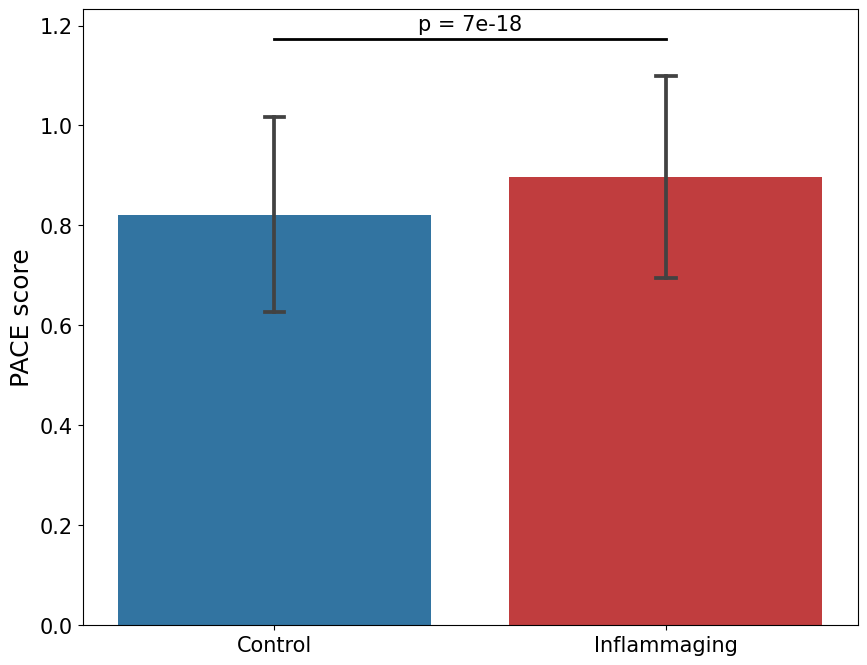

In [71]:
plt.figure(figsize=(10, 8)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]
    
custom_palette = {conditions[0]:blue, conditions[1]:red}
sns.barplot(data=comb_meta, x='healthy', y='PACE', palette=custom_palette, order=category_order,
            errorbar=('sd',1), capsize=0.05,linewidth=3)
# Add significance bar and p-value
plt.plot([0, 1], [max(d_resids)*(0.7), max(d_resids)*(0.7)], 'k-', lw=2)
plt.text(0.5, max(d_resids)*(0.71), f'p = {p_value:.1g}', ha='center', fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel(None)
plt.ylabel('PACE score',fontsize=18)
# plt.savefig('DuoAge/Figure 1/PACE boxplots.png')

# Plot the model error distributions

In [297]:
c_palette = sns.color_palette()
custom = c_palette[:3] + [c_palette[4]]+[c_palette[6]]+ c_palette[9:]

In [298]:
model_errors = pd.concat([horvath_fit, hannum_fit, pheno_fit, adapt_fit, dam_fit, caus_fit], axis=0)

In [299]:
d_model_errors = pd.concat([d_horvath_fit, d_hannum_fit, d_pheno_fit, d_adapt_fit, d_Dam_fit, d_Caus_fit], axis=0)

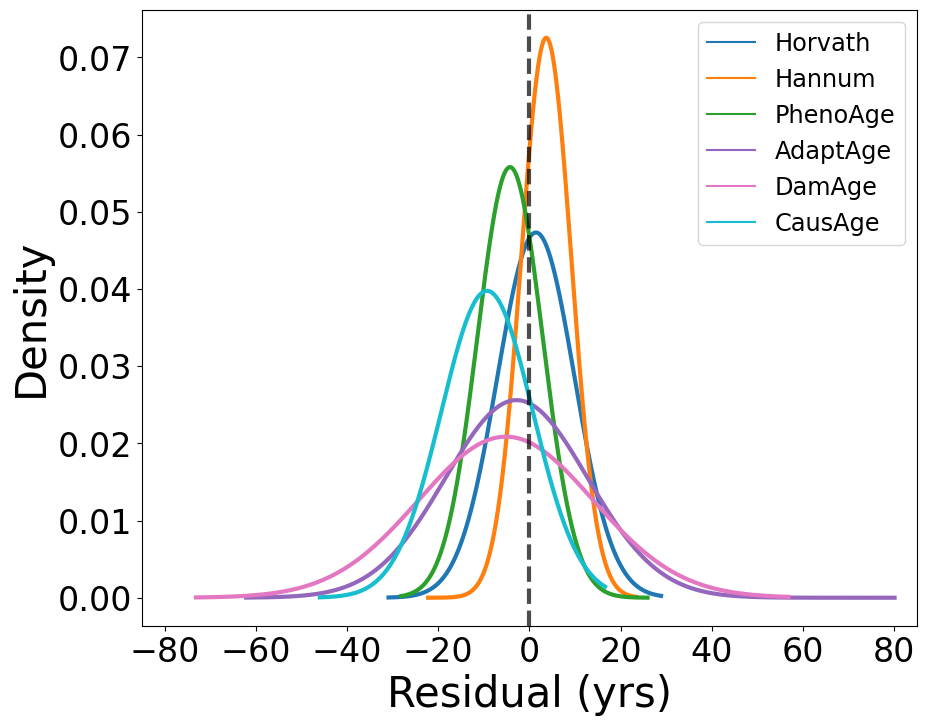

In [308]:
plt.figure(figsize=(10, 8)) 

sns.lineplot(model_errors, x='Error', y='Density', hue='Model', palette=custom, linewidth=3)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7, linewidth=3)

plt.xlim([-85,85])
plt.xlabel('Residual (yrs)',fontsize=30)
plt.ylabel('Density',fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize='xx-large', title_fontsize='50')
plt.savefig('FSWclock/Figure 2/Healthy model errors.png',dpi=300)

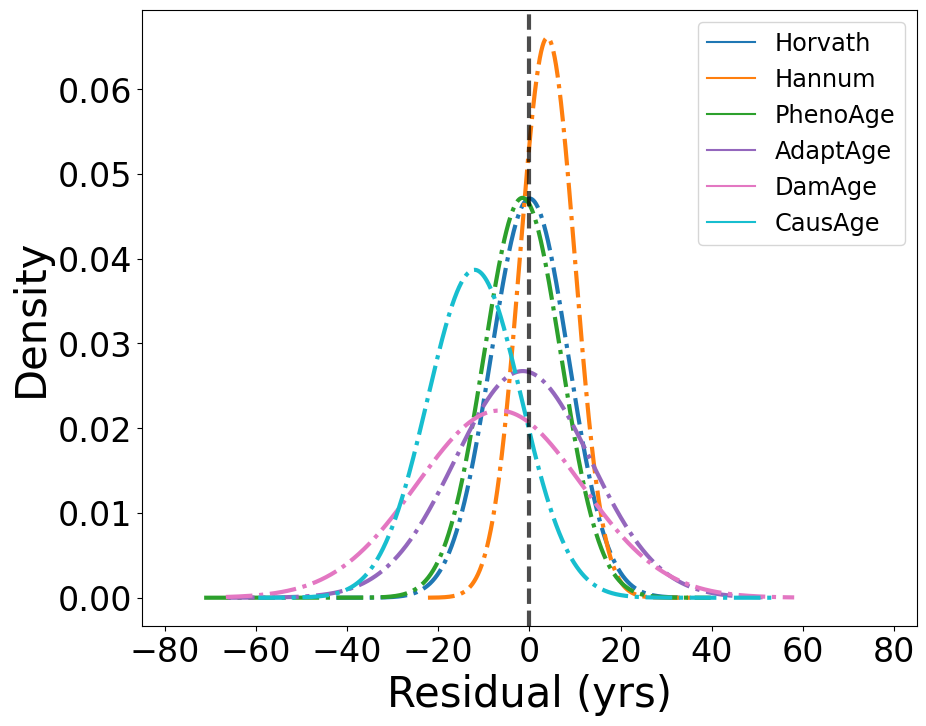

In [309]:
plt.figure(figsize=(10, 8)) 

sns.lineplot(d_model_errors, x='Error', y='Density', hue='Model', linestyle='-.', palette=custom, linewidth=3)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7, linewidth=3)

plt.xlim([-85,85])
plt.xlabel('Residual (yrs)',fontsize=30)
plt.ylabel('Density',fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize='xx-large', title_fontsize='50')
plt.savefig('FSWclock/Figure 2/Inflammaging model errors.png',dpi=300)

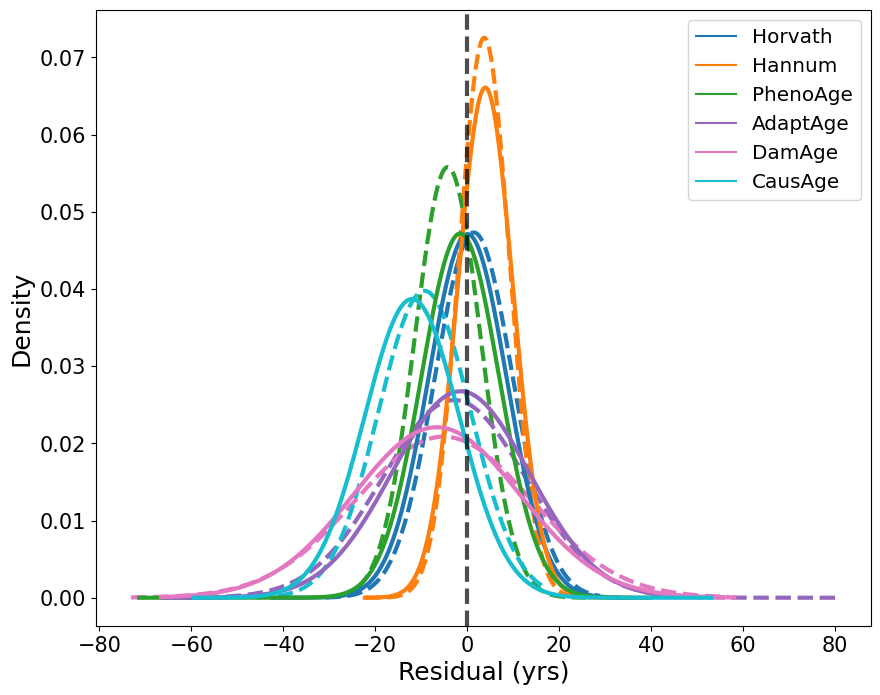

In [134]:
plt.figure(figsize=(10, 8)) 

sns.lineplot(model_errors, x='Error', y='Density', hue='Model', linestyle='--', palette=custom, linewidth=3)
sns.lineplot(d_model_errors, x='Error', y='Density', hue='Model', palette=custom, linewidth=3, legend=False)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7, linewidth=3)


plt.xlabel('Residual (yrs)',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='x-large', title_fontsize='50')
# plt.savefig('DuoAge/Figure 1/Model errors.png',dpi=300)

In [325]:
models = ['Horvath', 'Hannum', 'PhenoAge', 'AdaptAge', 'DamAge', 'CausAge']

In [326]:
cutoffs = [20,30,40,50,60,70,80]
cutoff_dict = {20: '20-29', 
            30: '30-39',
            40: '40-49',
            50: '50-59',
            60: '60-69',
            70: '70-79',
            80: '80-89'}

In [327]:
interval_fits={}
interval_stats={}

fit_df = pd.DataFrame(columns=['Error', 'Density', 'Cutoff', 'Model'])
stats_df = pd.DataFrame(columns=['Model','Cutoff', 'Mean', 'Stdev'])

for cutoff in cutoffs:

    temp = h_meta[(h_meta.age>=cutoff) & (h_meta.age<(cutoff+10))]
       

    for model in models:

        resids = list(temp[model]-temp.age)
        
        # Fit Normal distribution parameters
        params_norm = stats.norm.fit(resids)
        mu, std = params_norm

        # Create PDFs (probability density functions) of the fitted distributions
        xmin = min(resids)-10
        xmax = max(resids)+10
        model_x = np.linspace(xmin, xmax, 1000)
        model_densities = stats.norm.pdf(model_x, mu, std)

        fit_df = pd.concat([fit_df,pd.DataFrame({'Error': model_x, 'Density': model_densities, 'Cutoff': cutoff_dict[cutoff], 'Model': model})],axis=0)
        stats_df = pd.concat([stats_df,pd.DataFrame({'Model': model, 'Cutoff': cutoff_dict[cutoff], 'Mean': [mu], 'Stdev': [std]})],axis=0)
                            

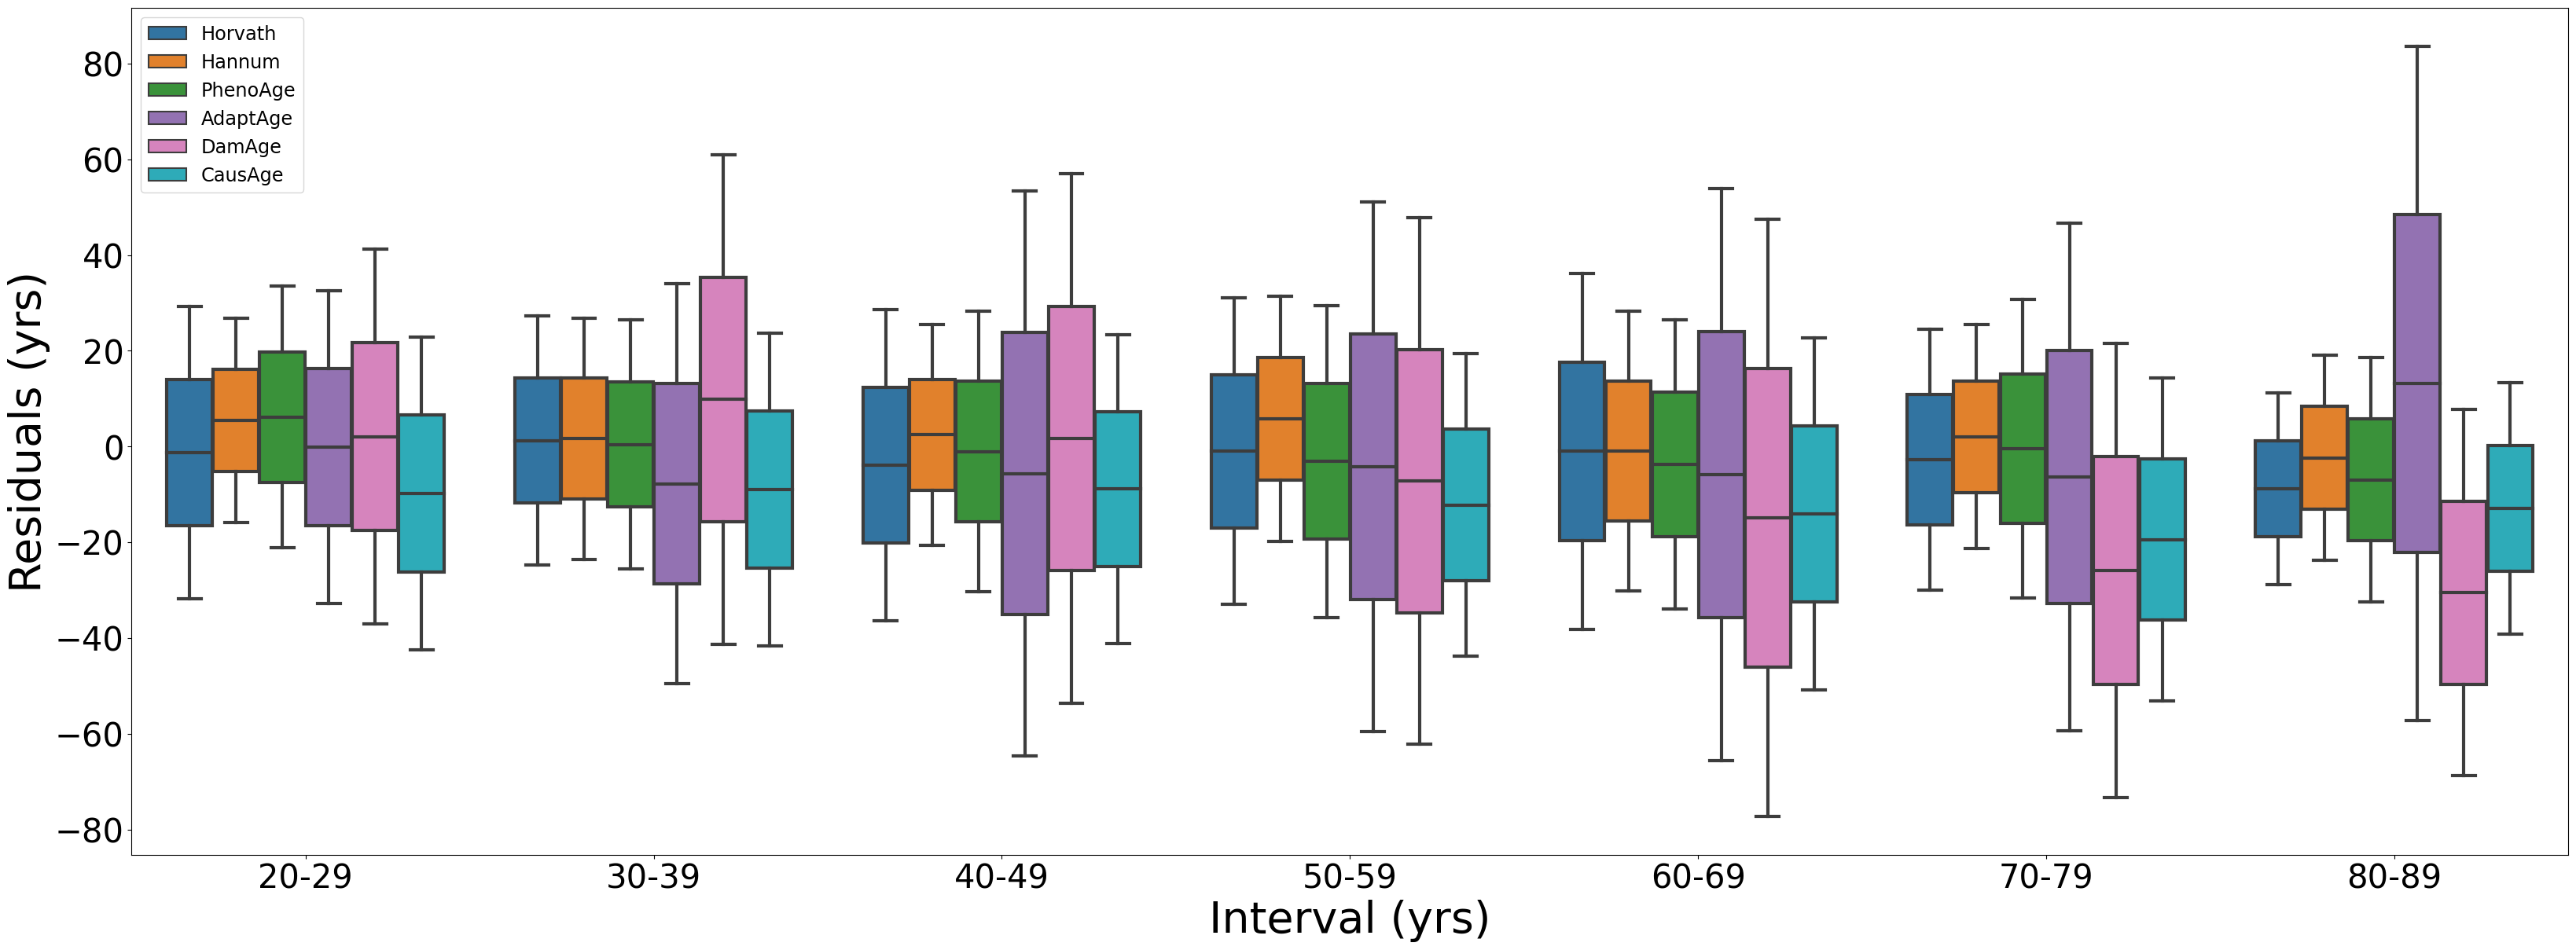

In [328]:
c_palette = sns.color_palette()
custom = c_palette[:3] + [c_palette[4]]+[c_palette[6]]+ c_palette[9:]

plt.figure(figsize=(40, 14)) 

sns.boxplot(fit_df, x='Cutoff', y='Error', hue='Model', palette=custom, linewidth=3)

plt.xlabel('Interval (yrs)',fontsize=40)
plt.ylabel('Residuals (yrs)',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize='xx-large', title_fontsize='200')
# plt.savefig('FSWclock/Supp fig 1/Model errors by interval.png',dpi=300)

In [331]:
hvd = comb_meta[['age','healthy']+models].copy()

In [332]:
# Replace values
hvd['healthy'] = hvd['healthy'].replace({0: 'Control', 1: 'Inflammaging'})

In [333]:
# Melt the DataFrame
melted_df = pd.melt(hvd, id_vars=['age', 'healthy'], var_name='Model', value_name='Prediction')

In [334]:
melted_df['Residual'] = melted_df.Prediction-melted_df.age

In [509]:
significances = []
sig_key = {(0.05,1):'n.s.',
           (0.01,0.05):'*',
           (0.001,0.01):'**',
           (0, 0.001):'***'}

for model in melted_df.Model.unique():
    
    temp = melted_df[melted_df.Model==model]
    
    h_resids = temp[temp.healthy=='Control'].Residual
    d_resids = temp[temp.healthy=='Inflammaging'].Residual
    # Perform the Welch's t-test (independent t-test with unequal variances)
    statistic, p_value = ttest_ind(h_resids, d_resids, equal_var=False)
    d = cohens_d(h_resids,d_resids)
    
    for range_, sig_symbol in sig_key.items():
        if range_[0] <= p_value < range_[1]:
            sig = sig_symbol
    
    significances +=[[model, p_value, sig, d]]

In [510]:
significances

[['Horvath', 0.00019858178782491495, '***', -0.1621051337606619],
 ['Hannum', 0.33773956074885436, 'n.s.', 0.04107288755628858],
 ['PhenoAge', 8.660491218576032e-16, '***', 0.3430175116469533],
 ['AdaptAge', 0.040264703364931966, '*', 0.0899817216793511],
 ['DamAge', 0.06753367049100985, 'n.s.', -0.08036791157233915],
 ['CausAge', 7.500954104791125e-10, '***', -0.2679435504716619]]

In [337]:
sns.set_palette('tab10')

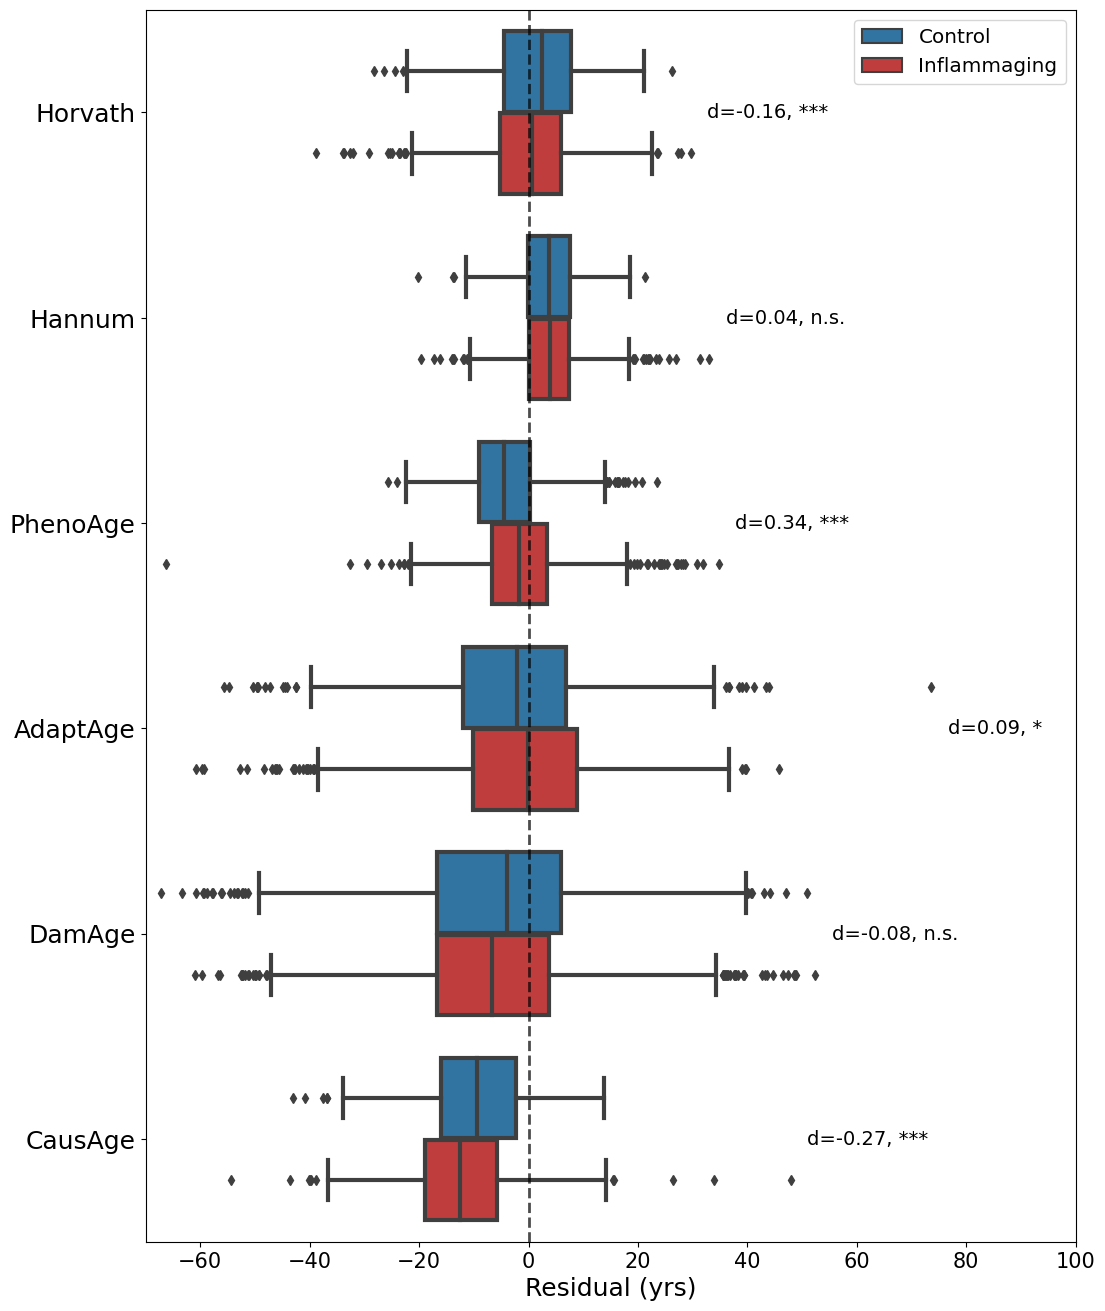

In [511]:
conditions=('Control','Inflammaging')
plt.figure(figsize=(12, 16)) 
blue = sns.color_palette()[0]
red=sns.color_palette()[3]
custom_palette = {conditions[0]:blue, conditions[1]:red}

# Define the desired order of categories
category_order = [conditions[0], conditions[1]]
sns.boxplot(melted_df,y='Model', x='Residual', hue='healthy', palette=custom_palette, linewidth=3)
plt.legend(loc='upper right', title='',fontsize='x-large')
plt.xlabel('Residual (yrs)',fontsize=18)
plt.ylabel('')
plt.xlim([-70,100])
plt.xticks(fontsize=15)
plt.yticks(fontsize=18)


for i in range(len(models)):
    
    max_val = melted_df[melted_df.Model==models[i]].Residual.max()
    plt.text(max_val+3, i,"d={:.2f}, {}".format(significances[i][3],significances[i][2]),
             ha='left', va='center', fontsize=14)  # Asterisks denoting significance level
    
# Add a dashed vertical line at x=0
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7, linewidth=2, zorder=10)
plt.savefig('FSWclock/Supp Fig 2/Health v disease.png',dpi=300)

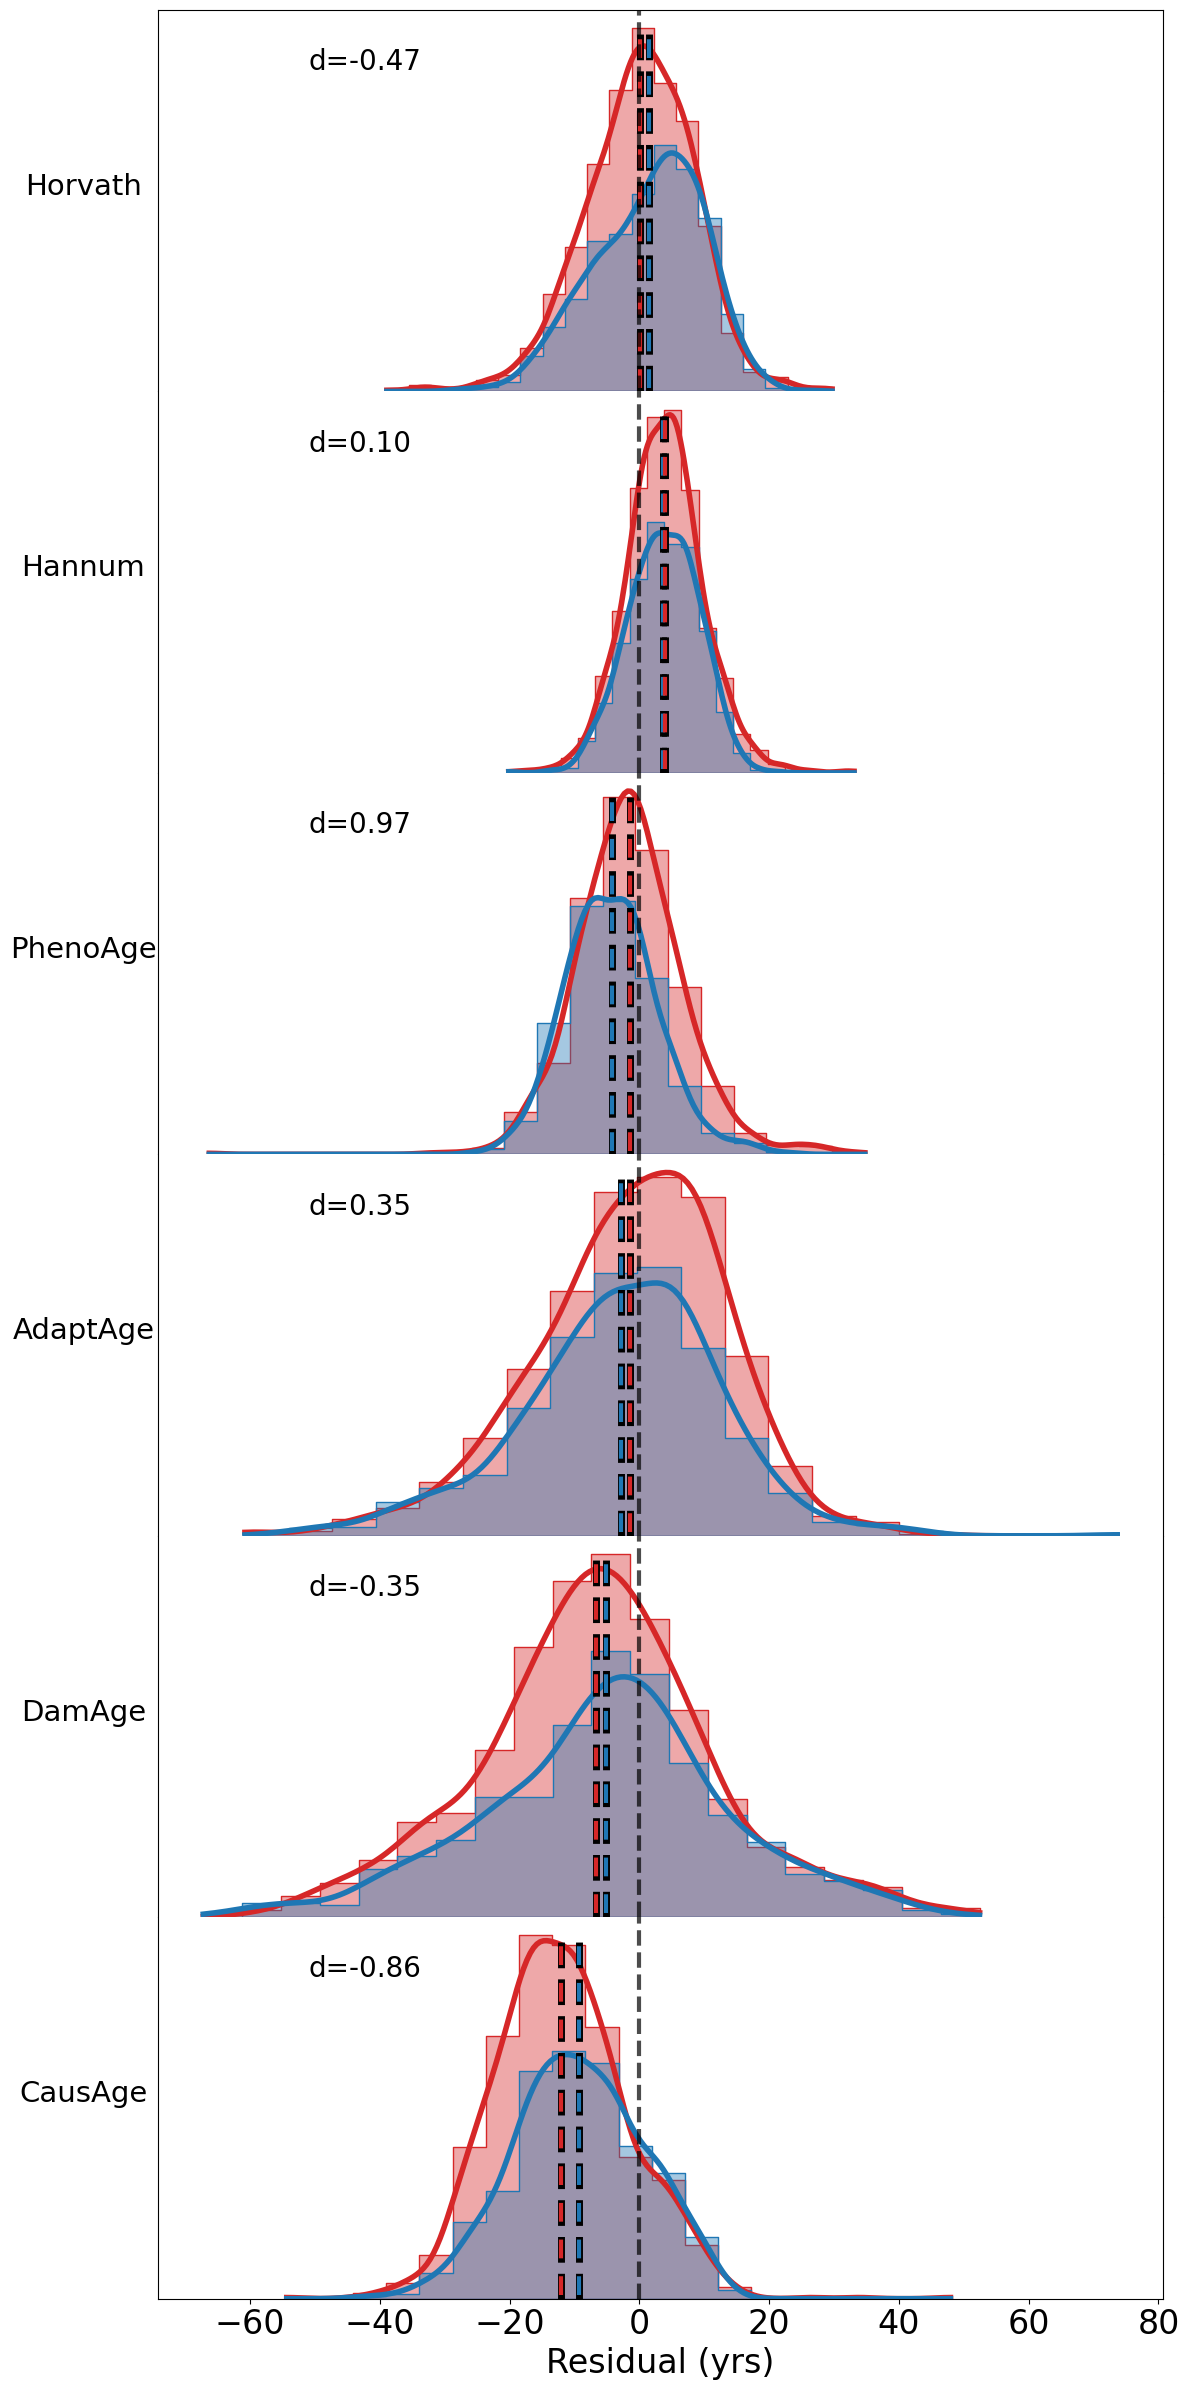

In [479]:
# Function to get significance and Cohen's d from the significances list
def get_significance_info(model, significances):
    for item in significances:
        if item[0] == model:
            p_value, significance, cohen_d = item[1], item[2], item[3]
            return p_value, significance, cohen_d
    return None, None, None

# Assuming melted_df is your DataFrame with columns 'Model', 'Residual', and 'healthy'
# Define the models you want to compare
models = melted_df['Model'].unique()
healthy_statuses = melted_df['healthy'].unique()

# Create a single figure with multiple subplots arranged vertically
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(12, len(models) * 4), sharex=True, gridspec_kw={'hspace': 0})

# Define custom palette
blue = sns.color_palette()[0]
red = sns.color_palette()[3]
custom_palette = {healthy_statuses[0]: blue, healthy_statuses[1]: red}

for i, model in enumerate(models):
    ax = axes[i]  # Get the specific subplot
    model_data = melted_df[melted_df['Model'] == model]

    sns.histplot(
        data=model_data,
        x='Residual',
        hue='healthy',
        palette=custom_palette,
        bins=20,
        kde=True,
        alpha=0.4,
        ax=ax,
        element="step",
        legend=False,
        line_kws={'linewidth': 4}
    )
    
    # Set model name as y-axis label
    ax.set_ylabel(f'{model}', fontsize=21, rotation=0, labelpad=50)
    ax.set_xlabel('Residual (yrs)', fontsize=24)

    # Remove density tick marks and density axis label
    ax.yaxis.set_ticks([])
    ax.set_yticklabels([])
    
    # Adjust the fontsize of the x-ticks for residuals
    ax.tick_params(axis='x', labelsize=24)

    # Plot means for each cohort (healthy status)
    mean_healthy = model_data[model_data['healthy'] == healthy_statuses[0]]['Residual'].mean()
    mean_unhealthy = model_data[model_data['healthy'] == healthy_statuses[1]]['Residual'].mean()
    ax.axvline(x=mean_healthy, color=blue, linestyle='--', linewidth=3, label=f'Mean {healthy_statuses[0]}',
               ymin=0.01, ymax=0.95, dashes=(4.5, 4.3),zorder=6)
    ax.axvline(x=mean_healthy, color='k', linestyle='--', linewidth=5, ymax=0.95, label=f'Mean {healthy_statuses[0]}')
    
    ax.axvline(x=mean_unhealthy, color=red, linestyle='--', linewidth=3, label=f'Mean {healthy_statuses[1]}',
              ymin=0.01,ymax=0.95, dashes=(4.5, 4.3),zorder=6)
    ax.axvline(x=mean_unhealthy, color='k', linestyle='--', linewidth=5, ymax=0.95, label=f'Mean {healthy_statuses[1]}')

    # Get precomputed p-value, significance, and Cohen's d
    p_value, significance, cohen_d = get_significance_info(model, significances)
    
    # Annotate Cohen's d on the plot using the Axes object
    if p_value is not None and significance is not None and cohen_d is not None:
        ax.text(0.15, 0.9, f"d={cohen_d:.2f}", transform=ax.transAxes, fontsize=20, verticalalignment='top')

    # Remove top and bottom borders for all but the first and last plot
    if i != 0:
        ax.spines['top'].set_visible(False)
    if i != len(models) - 1:
        ax.spines['bottom'].set_visible(False)

# Adjust layout to ensure everything fits without overlap
plt.tight_layout()

# Add a dashed vertical line at x=0 on all subplots
for ax in axes:
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.7, linewidth=3, zorder=10)

plt.savefig('FSWclock/Figure 2/Inflammaging model comparisons.png',dpi=300)

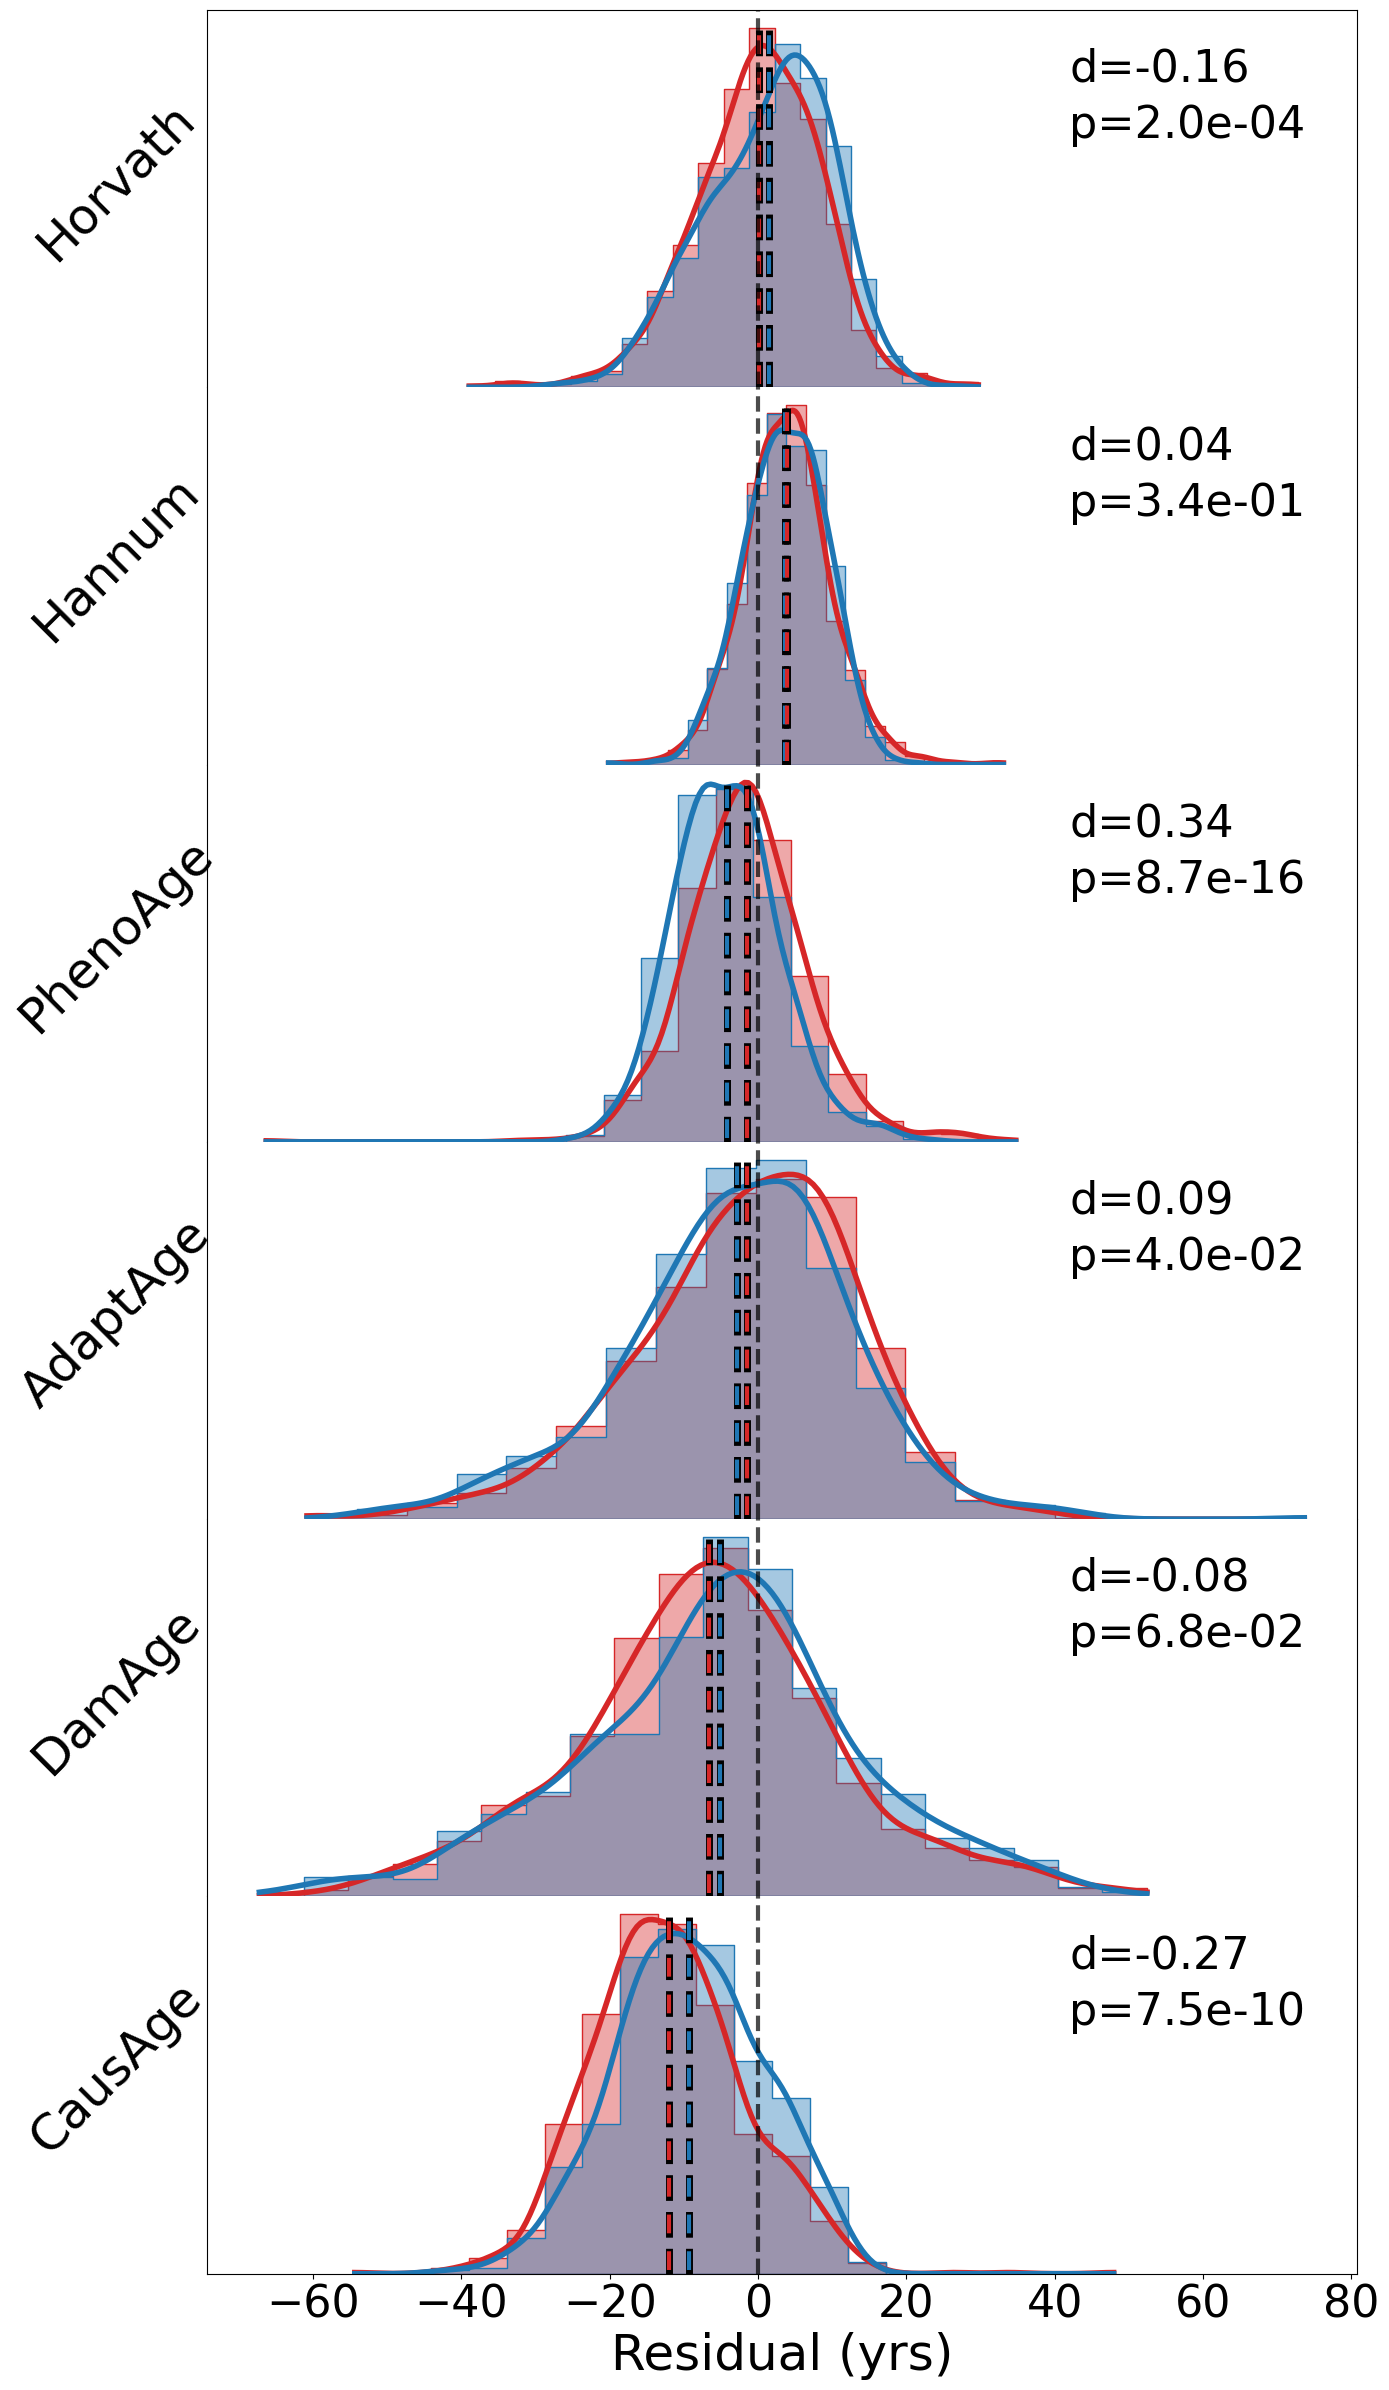

In [525]:
# Function to get significance and Cohen's d from the significances list
def get_significance_info(model, significances):
    for item in significances:
        if item[0] == model:
            p_value, significance, cohen_d = item[1], item[2], item[3]
            return p_value, significance, cohen_d
    return None, None, None

# Assuming melted_df is your DataFrame with columns 'Model', 'Residual', and 'healthy'
# Define the models you want to compare
models = melted_df['Model'].unique()
healthy_statuses = melted_df['healthy'].unique()

# Create a single figure with multiple subplots arranged vertically
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(14, len(models) * 4), sharex=True, gridspec_kw={'hspace': 0})

# Define custom palette
blue = sns.color_palette()[0]
red = sns.color_palette()[3]
custom_palette = {healthy_statuses[0]: blue, healthy_statuses[1]: red}

for i, model in enumerate(models):
    ax = axes[i]  # Get the specific subplot
    model_data = melted_df[melted_df['Model'] == model]

    sns.histplot(
        data=model_data,
        x='Residual',
        hue='healthy',
        palette=custom_palette,
        bins=20,
        kde=True,
        alpha=0.4,
        ax=ax,
        legend=False,
        element="step",
        stat="density",  # Normalize to percentage
        common_norm=False,  # Ensures separate normalization for each hue level
        line_kws={'linewidth': 4}
    )
    
    # Set model name as y-axis label
    ax.set_ylabel(f'{model}', fontsize=36, rotation=45, labelpad=50)
    ax.set_xlabel('Residual (yrs)', fontsize=36)

    # Remove density tick marks and density axis label
    ax.yaxis.set_ticks([])
    ax.set_yticklabels([])
    
    # Adjust the fontsize of the x-ticks for residuals
    ax.tick_params(axis='x', labelsize=32)

    # Plot means for each cohort (healthy status)
    mean_healthy = model_data[model_data['healthy'] == healthy_statuses[0]]['Residual'].mean()
    mean_unhealthy = model_data[model_data['healthy'] == healthy_statuses[1]]['Residual'].mean()
    ax.axvline(x=mean_healthy, color=blue, linestyle='--', linewidth=3, label=f'Mean {healthy_statuses[0]}',
               ymin=0.01, ymax=0.95, dashes=(4.5, 4.3), zorder=6)
    ax.axvline(x=mean_healthy, color='k', linestyle='--', linewidth=5, ymax=0.95, label=f'Mean {healthy_statuses[0]}')
    
    ax.axvline(x=mean_unhealthy, color=red, linestyle='--', linewidth=3, label=f'Mean {healthy_statuses[1]}',
               ymin=0.01, ymax=0.95, dashes=(4.5, 4.3), zorder=6)
    ax.axvline(x=mean_unhealthy, color='k', linestyle='--', linewidth=5, ymax=0.95, label=f'Mean {healthy_statuses[1]}')

    # Get precomputed p-value, significance, and Cohen's d
    p_value, significance, cohen_d = get_significance_info(model, significances)
    
    # Annotate Cohen's d on the plot using the Axes object
    if p_value is not None and significance is not None and cohen_d is not None:
        ax.text(0.75, 0.9, f"d={cohen_d:.2f}", transform=ax.transAxes, fontsize=32, verticalalignment='top')
        ax.text(0.75, 0.75, f"p={p_value:.1e}", transform=ax.transAxes, fontsize=32, verticalalignment='top')

    # Remove top and bottom borders for all but the first and last plot
    if i != 0:
        ax.spines['top'].set_visible(False)
    if i != len(models) - 1:
        ax.spines['bottom'].set_visible(False)

# Adjust layout to ensure everything fits without overlap
plt.tight_layout()

# Add a dashed vertical line at x=0 on all subplots
for ax in axes:
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.7, linewidth=3, zorder=10)

plt.savefig('FSWclock/Figure 2/Inflammaging model comparisons normalized.png',dpi=300)

In [87]:
h_horvath= pd.read_pickle('Models/horvath/Healthy.pkl')
d_horvath= pd.read_pickle('Models/horvath/Disease.pkl')
h_hannum= pd.read_pickle('Models/hannum/Healthy.pkl')
d_hannum= pd.read_pickle('Models/hannum/Disease.pkl')
h_phenoage= pd.read_pickle('Models/phenoage/Healthy.pkl')
d_phenoage= pd.read_pickle('Models/phenoage/Disease.pkl')
h_pace= pd.read_pickle('Models/Pace/Healthy.pkl')
d_pace= pd.read_pickle('Models/Pace/Disease.pkl')
h_adapt= pd.read_pickle('Models/AdaptAge/Healthy.pkl')
d_adapt= pd.read_pickle('Models/AdaptAge/Disease.pkl')
h_dam= pd.read_pickle('Models/DamAge/Healthy.pkl')
d_dam= pd.read_pickle('Models/DamAge/Disease.pkl')
h_caus=pd.read_pickle('Models/CausAge/Healthy.pkl')
d_caus=pd.read_pickle('Models/CausAge/Disease.pkl')

In [81]:
horvath_corrs= pd.read_excel('Models/horvath/stats.xlsx')
hannum_corrs= pd.read_excel('Models/hannum/stats.xlsx')
phenoage_corrs= pd.read_excel('Models/phenoage/stats.xlsx')
pace_corrs= pd.read_excel('Models/pace/stats.xlsx')
adapt_corrs= pd.read_excel('Models/AdaptAge/stats.xlsx')
dam_corrs= pd.read_excel('Models/DamAge/stats.xlsx')
caus_corrs=pd.read_excel('Models/CausAge/stats.xlsx')

# Calculate p-val for U-test for each model

In [85]:
adapt_u, adapt_p, adapt_logp = u_test(adapt, h_adapt, d_adapt)
adapt_corrs['u-stat']= adapt_u
adapt_corrs['mann-p']= adapt_p
adapt_corrs['log_p'] = adapt_logp

In [93]:
dam_u, dam_p, dam_logp = u_test(dam, h_dam, d_dam)
dam_corrs['u-stat']= dam_u
dam_corrs['mann-p']= dam_p
dam_corrs['log_p'] = dam_logp

In [94]:
caus_u, caus_p, caus_logp = u_test(caus, h_caus, d_caus)
caus_corrs['u-stat']= caus_u
caus_corrs['mann-p']= caus_p
caus_corrs['log_p'] = caus_logp

In [95]:
horvath_u, horvath_p, horvath_logp = u_test(horvath, h_horvath, d_horvath)
horvath_corrs['u-stat']= horvath_u
horvath_corrs['mann-p']= horvath_p
horvath_corrs['log_p'] = horvath_logp

In [96]:
hannum_u, hannum_p, hannum_logp = u_test(hannum, h_hannum, d_hannum)
hannum_corrs['u-stat']= hannum_u
hannum_corrs['mann-p']= hannum_p
hannum_corrs['log_p'] = hannum_logp

In [97]:
phenoage_u, phenoage_p, phenoage_logp = u_test(phenoage, h_phenoage, d_phenoage)
phenoage_corrs['u-stat']= phenoage_u
phenoage_corrs['mann-p']= phenoage_p
phenoage_corrs['log_p'] = phenoage_logp

In [98]:
pace_u, pace_p, pace_logp = u_test(pace, h_pace, d_pace)
pace_corrs['u-stat']= pace_u
pace_corrs['mann-p']= pace_p
pace_corrs['log_p'] = pace_logp

In [99]:
adapt_corrs[adapt_corrs.importance == 1]

Unnamed: 0         CpG     Weight         r             t        R2  \
218         218  cg05003422  64.734753 -0.226612  4.304941e+06  0.051353   

     importance    het_rs    u-stat    mann-p     log_p     model  
218         1.0  0.004384  610085.5  0.013175  1.880254  AdaptAge

In [171]:
# h_meta['state'] = 'Healthy control'
# d_meta['state'] = 'Inflammaging'
# h_meta['coi'] =  h_adapt['cg05003422']
# d_meta['coi'] =  d_adapt['cg05003422']
# temp_comb=pd.concat([h_meta,d_meta], axis=0)

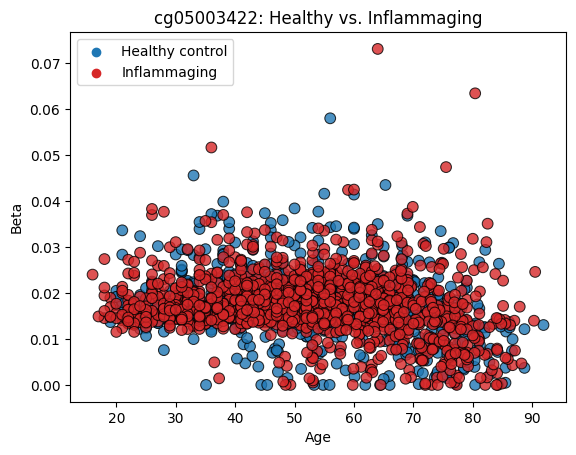

In [212]:
conditions = ('Healthy control','Inflammaging')

blue = sns.color_palette()[0]
red=sns.color_palette()[3]
    
custom= {conditions[0]:blue, conditions[1]:red}

sns.scatterplot(data = temp_comb, x='age', y='coi', hue='state', s=60, palette = custom, alpha = 0.8, 
                edgecolor='k', linewidth=0.75)
plt.xlabel("Age")
plt.ylabel("Beta")
plt.legend(loc='upper left', title='')
plt.title("cg05003422: Healthy vs. Inflammaging")
plt.savefig('DuoAge/Supp fig 1/AdaptAge top cg.png',dpi=300)

In [257]:
horvath_corrs['model'] = 'Horvath'
hannum_corrs['model'] = 'Hannum'
phenoage_corrs['model'] = 'PhenoAge'
pace_corrs['model'] = 'PACE'
adapt_corrs['model'] = 'AdaptAge'
dam_corrs['model'] = 'DamAge'
caus_corrs['model'] = 'CausAge'

In [103]:
comb_corrs = pd.concat([horvath_corrs,hannum_corrs,phenoage_corrs,pace_corrs,adapt_corrs,dam_corrs, caus_corrs], axis=0)

In [110]:
c_palette = sns.color_palette()
custom = c_palette[:5] + [c_palette[6]]+ c_palette[9:]

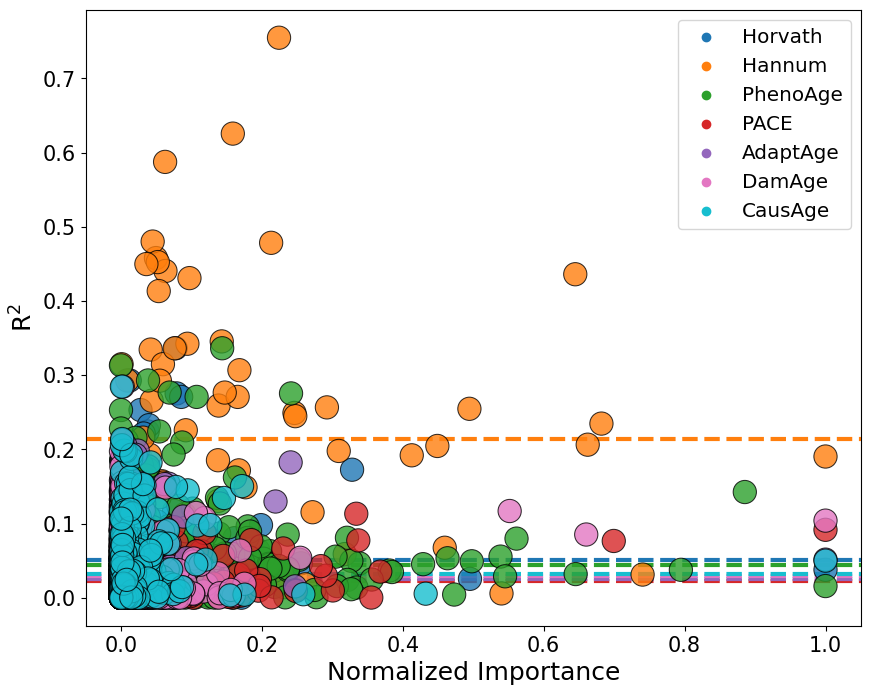

In [113]:
plt.figure(figsize=(10, 8)) 

sns.scatterplot(data=comb_corrs,x='importance', y='R2', hue='model', palette = custom
                ,s=280, alpha=0.8, edgecolor="k", linewidth=0.75 ,zorder=10)

plt.axhline(y=horvath_corrs['R2'].mean(),color=custom[0], linestyle='--',linewidth=3, zorder=1)
plt.axhline(y=hannum_corrs['R2'].mean(),color=custom[1], linestyle='--',linewidth=3, zorder=1)
plt.axhline(y=phenoage_corrs['R2'].mean(),color=custom[2], linestyle='--',linewidth=3, zorder=1)
plt.axhline(y=pace_corrs['R2'].mean(),color=custom[3], linestyle='--',linewidth=3)
plt.axhline(y=adapt_corrs['R2'].mean(),color=custom[4], linestyle='--',linewidth=3)
plt.axhline(y=dam_corrs['R2'].mean(),color=custom[5], linestyle='--',linewidth=3)
plt.axhline(y=caus_corrs['R2'].mean(),color=custom[6], linestyle='--',linewidth=3)

plt.xlabel('Normalized Importance',fontsize=18)
plt.ylabel('R$^2$',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='x-large', title_fontsize='50')
plt.savefig('DuoAge/Figure 1/R2 v Importance.png',dpi=300)

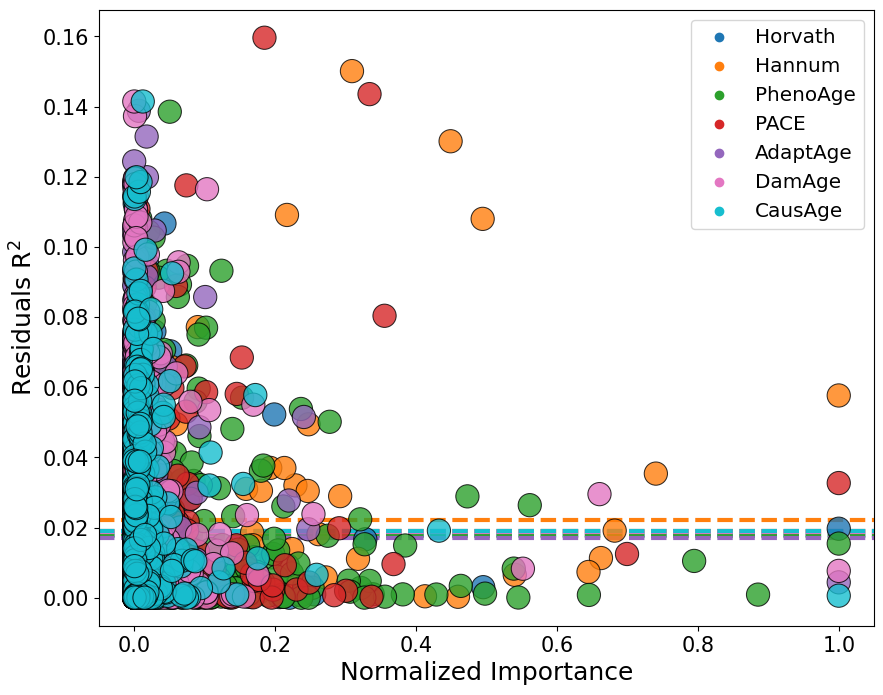

In [115]:
plt.figure(figsize=(10, 8)) 

sns.scatterplot(data=comb_corrs,x='importance', y='het_rs', hue='model', palette = custom
                ,s=280, alpha=0.8, edgecolor="k", linewidth=0.75,zorder=10)

plt.axhline(y=horvath_corrs['het_rs'].mean(),color=custom[0], linestyle='--',linewidth=3, zorder=1)
plt.axhline(y=hannum_corrs['het_rs'].mean(),color=custom[1], linestyle='--',linewidth=3, zorder=1)
plt.axhline(y=phenoage_corrs['het_rs'].mean(),color=custom[2], linestyle='--',linewidth=3, zorder=1)
plt.axhline(y=pace_corrs['het_rs'].mean(),color=custom[3], linestyle='--',linewidth=3)
plt.axhline(y=adapt_corrs['het_rs'].mean(),color=custom[4], linestyle='--',linewidth=3)
plt.axhline(y=dam_corrs['het_rs'].mean(),color=custom[5], linestyle='--',linewidth=3)
plt.axhline(y=caus_corrs['het_rs'].mean(),color=custom[6], linestyle='--',linewidth=3)

plt.xlabel('Normalized Importance',fontsize=18)
plt.ylabel('Residuals R$^2$',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='x-large', title_fontsize='50')
plt.savefig('DuoAge/Figure 1/het_rs v Importance.png',dpi=300)

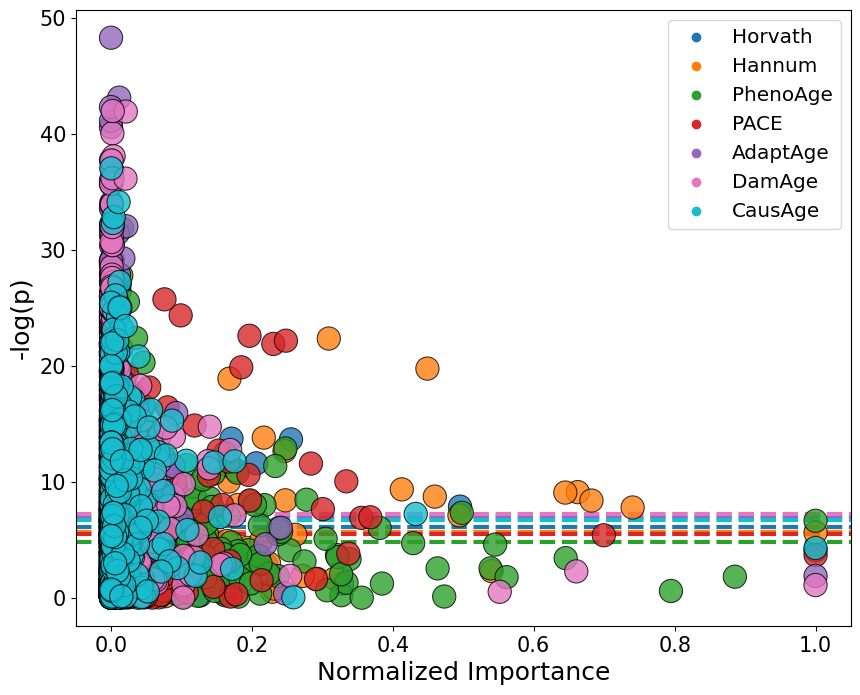

In [116]:
plt.figure(figsize=(10, 8)) 

sns.scatterplot(data=comb_corrs,x='importance', y='log_p', hue='model', palette = custom
                ,s=280, alpha=0.8, edgecolor="k", linewidth=0.75,zorder=10)

plt.axhline(y=horvath_corrs['log_p'].mean(),color=custom[0], linestyle='--',linewidth=3, zorder=1)
plt.axhline(y=hannum_corrs['log_p'].mean(),color=custom[1], linestyle='--',linewidth=3, zorder=1)
plt.axhline(y=phenoage_corrs['log_p'].mean(),color=custom[2], linestyle='--',linewidth=3, zorder=1)
plt.axhline(y=pace_corrs['log_p'].mean(),color=custom[3], linestyle='--',linewidth=3)
plt.axhline(y=adapt_corrs['log_p'].mean(),color=custom[4], linestyle='--',linewidth=3)
plt.axhline(y=dam_corrs['log_p'].mean(),color=custom[5], linestyle='--',linewidth=3)
plt.axhline(y=caus_corrs['log_p'].mean(),color=custom[6], linestyle='--',linewidth=3)

plt.xlabel('Normalized Importance',fontsize=18)
plt.ylabel('-log(p)',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='x-large', title_fontsize='50')
plt.savefig('DuoAge/Figure 1/log_p v Importance.png',dpi=300)

In [249]:
n = 4

In [227]:
top=adapt_corrs[adapt_corrs.R2 == adapt_corrs.R2.max()].CpG

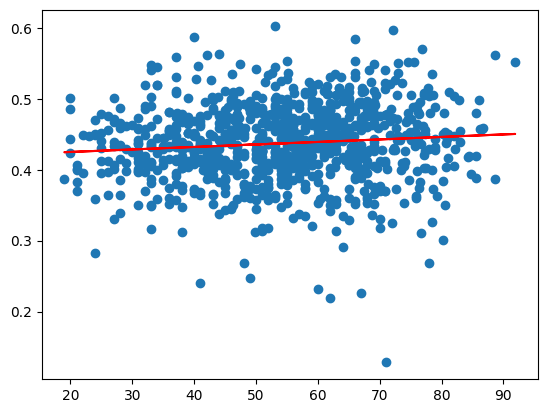

In [250]:
#regress a given predictor on age
regression = stats.linregress(h_meta.age.astype(float), comb[adapt_corrs.CpG[n]].astype(float))
slope, intercept, rvalue, pvalue, stderr = regression
preds = slope*h_meta.age+intercept

plt.scatter(h_meta.age, comb[adapt_corrs.CpG[n]])
plt.plot(h_meta.age, preds, color='red')